# Project Description

****Project Description****

This project was developed for an HR analytics consulting company specializing in workforce optimization and employee retention strategies. The objective was to leverage machine learning to support data-driven HR decision-making and reduce financial losses associated with employee turnover.

The company provided structured employee data, including demographic, performance, and workplace-related characteristics. One of the key variables was employee job satisfaction, measured on a continuous scale from 0 to 1 based on internal survey results.

Because conducting large-scale employee satisfaction surveys is operationally complex and resource-intensive, the business required a scalable predictive solution capable of estimating satisfaction levels without repeatedly relying on costly data collection efforts.


****Research Objective****

* Identify the key factors that influence employee satisfaction and the likelihood of resignation.

* Build and compare machine learning models to predict satisfaction level and employee attrition, selecting the best ones based on the SMAPE metric (for regression) and ROC-AUC (for classification).

* Based on the results, identify at-risk groups and develop practical recommendations for the HR department to increase engagement and reduce staff turnover.


****Study Workflow****

1. [Task 1: Predicting an employee’s satisfaction level](#task_1)

   1.1 [Data loading](#data_loading)\
   1.2 [Data preprocessing](#data_preprocessing)\
   1.3 [Exploratory data analysis](#exploratory_data_analysis)\
   1.4 [Correlation analysis](#correlation_analysis)\
   1.5 [Using pipelines](#using_pipelines)\
   1.6 [Conclusion and findings](#conclusion_findings)\

2. [Task 2: Predicting employee attrition (leaving the company)](#task_2)

   2.1 [Data loading](#data_loading_2)\
   2.2 [Data preprocessing](#data_preprocessing_2)\
   2.3 [Exploratory data analysis](#exploratory_data_analysis_2)\
   2.4 [Correlation analysis](#correlation_analysis_2)\
   2.5 [Profile of an employee who resigned](#resigned_employee)\
   2.6 [Testing the statement: “An employee’s job satisfaction level (job_satisfaction_rate) affects whether the employee will leave.”](#hypothesis_test)\
   2.7 [Adding a new input feature](#feature_addition)\
   2.8 [Data preparation](#data_preparation)\
   2.9 [Model training (Task 2: predict quit)](#model_training)

3. [Overall project conclusion](#overall_conclusion)


## Task 1: Predicting an Employee’s Satisfaction Level <a id="task_1"></a>

### Data Loading <a id="data_loading"></a>

In [1]:
# To install the 'phik' module
!pip install -q phik

In [2]:
# Updating scikit-learn
!pip install -q -U scikit-learn

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings, re
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

In [4]:
# Environment settings and project constants
warnings.filterwarnings(
    "ignore",
    message=".*keepdims.*",
    category=FutureWarning
)

RANDOM_STATE = 42

In [5]:
# Loading datasets
train = pd.read_csv('../data/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('../data/test_features.csv')
test_target = pd.read_csv('../data/test_target_job_satisfaction_rate.csv')

### Data Preprocessing <a id="data_preprocessing"></a>

__Создадим функцию для вывода нужных характеристик (head, info, describe, пропуски, дубликаты, уникальные значения)__

In [6]:
def look_data(x):
    print('------------- Original DataFrame (first 5 rows) -------------')
    display(x.head())
    print('\n\n')

    print('------------- General DataFrame information -------------')
    print('\n')
    display(x.info())

    print('------------- Number of missing values in the DataFrame -------------')
    print('\n')
    display(x.isna().sum())

    print('------------- Number of explicit duplicates in the DataFrame -------------')
    display(x.duplicated().sum())
    print('\n\n')

    print('------------- Descriptive statistics -------------')
    display(x.drop(columns=['id']).describe())

    print('------------- Checking unique values of non-numeric columns -------------')
    print('\n')
    object_cols = x.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = x[col].unique()
        print(f"Column: {col}")
        print(f"Number of unique values: {len(unique_vals)}")
        print(f"Unique values: {unique_vals}")
        print('-' * 60)

#### Displaying Required Characteristics — Training Dataset

In [7]:
# Displaying the required characteristics (head, info, describe, missing values, duplicates, unique values)
look_data(train)

------------- Original DataFrame (first 5 rows) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

------------- Number of missing values in the DataFrame -------------




id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


------------- Checking unique values of non-numeric columns -------------


Column: dept
Number of unique values: 6
Unique values: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
------------------------------------------------------------
Column: level
Number of unique values: 4
Unique values: ['junior' 'middle' 'sinior' nan]
------------------------------------------------------------
Column: workload
Number of unique values: 3
Unique values: ['medium' 'high' 'low']
------------------------------------------------------------
Column: last_year_promo
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------
Column: last_year_violations
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------


##### Short Summary of the **Training Dataset**

1. **Size, data types, target variable**

* 4,000 rows × 10 columns.
* Data types: 5 object, 4 integer, 1 float.
* The target variable `job_satisfaction_rate` is present in this DataFrame and has no missing values.

2. **Missing values and duplicates**

* Missing values: `dept` — 6 (≈0.15%), `level` — 4 (≈0.10%); all other columns — 0.
* Explicit duplicate rows — 0.

3. **Categorical features (unique values)**

* `dept`: 6 categories — `['sales', 'hr', 'technology', 'purchasing', 'marketing', NaN]`.
* `level`: 3 valid categories — `['junior', 'middle', 'sinior', NaN]`; there is a typo **'sinior'** (should be corrected to `'senior'`).
* `workload`: 3 categories — `['medium', 'high', 'low']`.
* `last_year_promo` / `last_year_violations`: binary — `['no', 'yes']`.

4. **Numerical features — key statistics**

* `employment_years`: min = 1, Q1 = 2, median = 3, mean = 3.72, Q3 = 6, max = 10.
* `supervisor_evaluation`: range 1–5, median = 4, mean ≈ 3.48.
* `salary`: min = 12,000, Q1 = 22,800, median = 30,000, Q3 = 43,200, max = 98,400, mean ≈ 33,927.
* `job_satisfaction_rate`: range 0.03–1.00, median = 0.56, mean ≈ 0.534, std ≈ 0.225 (concentrated around mid-range values).

5. **Implications for preprocessing**

* Fix the typo in `level`: `'sinior'` → `'senior'`.
* Impute missing values in `dept` and `level` (most frequent value or a separate category).
* Encode categorical features (One-Hot / Ordinal depending on the chosen model).
* Scale numerical features, at least `salary` (significant scale difference).
* Additionally: check for outliers in `salary` and ensure category consistency between train and test sets after cleaning.


##### Fixing the typo in `level`: `'sinior'` → `'senior'`

In [8]:
train.loc[:, 'level'] = train['level'].replace('sinior', 'senior')

****Verification****

In [9]:
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

****All typos `'sinior'` have been corrected to `'senior'`****

#### Displaying Required Characteristics — Test Dataset Input Features

In [10]:
# Displaying the required characteristics (head, info, describe, missing values, duplicates, unique values)
look_data(test_features)

------------- Original DataFrame (first 5 rows) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------- Number of missing values in the DataFrame -------------




id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Checking unique values of non-numeric columns -------------


Column: dept
Number of unique values: 7
Unique values: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
------------------------------------------------------------
Column: level
Number of unique values: 4
Unique values: ['junior' 'middle' 'sinior' nan]
------------------------------------------------------------
Column: workload
Number of unique values: 4
Unique values: ['medium' 'low' 'high' ' ']
------------------------------------------------------------
Column: last_year_promo
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------
Column: last_year_violations
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------


##### Short Summary of the **Test Dataset Input Features**

1. **Size and data types**

* 2,000 rows × 9 columns.
* Data types: 5 object, 4 integer.
* The target variable is absent in this file (features only).

2. **Missing values and duplicates**

* Missing values: `dept` — 2 (0.1%), `level` — 1 (0.05%); all other columns — 0.
* Explicit duplicate rows — 0.

3. **Categorical features (unique values)**

* `dept`: 7 categories — `['marketing', 'hr', 'sales', 'purchasing', 'technology', NaN, **' '**]` → there is an empty string **' '** acting as a “garbage” category.
* `level`: 4 levels — `['junior', 'middle', **'sinior'**, NaN]` → typo **'sinior'** (should be replaced with `'senior'`).
* `workload`: 4 values — `['medium', 'low', 'high', **' '**]` → extra empty value **' '** (needs normalization).
* `last_year_promo` / `last_year_violations`: binary — `['no', 'yes']`.

4. **Numerical features — key statistics**

* `employment_years`: min = 1, Q1 = 1, median = 3, mean = 3.667, Q3 = 6, max = 10.
* `supervisor_evaluation`: range 1–5, median = 4, mean ≈ 3.527.
* `salary`: min = 12,000, Q1 = 22,800, median = 30,000, Q3 = 43,200, max = 96,000, mean ≈ 34,067.
* `id`: range 100,298–999,029 (technical identifier).

5. **Implications for preprocessing**

* Convert empty strings **' '** in `dept` and `workload` to NaN (then handle missing values) or treat them as a separate category.
* Fix the typo in `level`: **'sinior' → 'senior'** (and keep it consistent with the training set).
* Impute NaN and empty values in `dept` and `level` (most frequent value or a separate category).
* Encode categorical features (One-Hot / Ordinal) and scale numerical features if needed (especially **salary**).
* After cleaning, verify category consistency between train and test datasets.


****There is also an empty string represented by a space **' '******

In [11]:
test_features[test_features['dept']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


__ID 822186__

In [12]:
for_822186 = test_features[
    (test_features['level'] == 'middle') &
    (test_features['workload'] == 'medium') &
    (test_features['employment_years'] == 3) &
    (test_features['salary'] == 38400) &
    (test_features['last_year_promo'] == 'no') &
    (test_features['last_year_violations'] == 'no') &
    (test_features['supervisor_evaluation'] == 4)
]
for_822186

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1048,995943,sales,middle,medium,3,no,no,4,38400
1699,822186,,middle,medium,3,no,no,4,38400
1724,273718,sales,middle,medium,3,no,no,4,38400


* A comparison with employees who have similar characteristics shows that most of them work in the **sales** department.

* Assigned department: **sales**

**Filling in the missing value represented by a space**

In [13]:
test_features.loc[test_features['id'] == 822186, 'dept'] = for_822186['dept'].mode()[0]

**Verification**

In [14]:
test_features[test_features['id'] == 822186]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,sales,middle,medium,3,no,no,4,38400


##### Handling missing values represented by a space in the `workload` column — Test Dataset Input Features


In [15]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


****There is 1 empty value represented by a space in the `workload` column in the dataset.****

To restore it, an analysis of the corresponding row was performed, selecting similar records based on the remaining features: `dept`, `level`, `employment_years`, `last_year_promo`, `last_year_violations`, `supervisor_evaluation`, and `salary`.

This approach makes it possible to logically determine which `workload` category the employee with the missing value most likely belongs to, based on the typical characteristics of comparable employees.


****Searching for similar records****

__ID 590867__

In [16]:
for_590867= test_features[
    (test_features['dept'] == 'marketing') &
    (test_features['level'] == 'junior') &
    (test_features['employment_years'] == 4) &
    (test_features['salary'] >= 26000) &
    (test_features['salary'] <= 32800) &
    (test_features['last_year_promo'] == 'no') &
    (test_features['last_year_violations'] == 'no') &
    (test_features['supervisor_evaluation'] == 4)
]
for_590867

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
539,264208,marketing,junior,medium,4,no,no,4,27600
1392,667957,marketing,junior,medium,4,no,no,4,31200


* A comparison with employees with similar characteristics shows that most of them work in the **sales** department.

* Assigned department: **sales**

**Filling in the missing value**

In [17]:
test_features.loc[test_features['id'] == 590867, 'workload'] = for_590867['workload'].mode()[0]

Verification

In [18]:
test_features[test_features['id'] == 590867]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,medium,4,no,no,4,28800


****Checking the `workload` column for missing values represented by a space****


In [19]:
test_features[test_features['workload']==' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


##### Fixing the typo in `level`: `'sinior'` → `'senior'`

In [20]:
test_features.loc[:, 'level'] = test_features['level'].replace('sinior', 'senior')

__Verification__

In [21]:
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

#### Displaying Required Characteristics — Test Dataset Target Variable

In [22]:
# Displaying the required characteristics (head, info, describe, missing values, duplicates, unique values)
look_data(test_target)

------------- Original DataFrame (first 5 rows) -------------


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

------------- Number of missing values in the DataFrame -------------




id                       0
job_satisfaction_rate    0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


------------- Checking unique values of non-numeric columns -------------




****Short Summary of the “Test Dataset Target Variable”****

1. **Size and data types**

* 2,000 rows × 2 columns.
* Data types: `id` — int, `job_satisfaction_rate` — float.

2. **Missing values and duplicates**

* Missing values: `id` — 0, `job_satisfaction_rate` — 0.
* Explicit duplicate rows — 0.

3. **Target variable (`job_satisfaction_rate`) — key statistics**

* Range: 0.03–1.00.
* Central tendency: median = 0.58, mean ≈ 0.549, std ≈ 0.220.
* Interquartile range: Q1 = 0.38, Q3 = 0.72 (skewed toward medium/high values).

4. **Identifier `id`**

* A technical key for joining with `test_features`; distributed from 100,298 to 999,029.

5. **Implications for preprocessing / validation**

* Verify that all `id`s in `test_target` match those in `test_features` (completeness and no “orphan” rows).
* Do not use `id` as a model feature.
* No scaling of the target variable is required (already in the [0, 1] range).


#### Summary of Completed Actions

****Feature preprocessing has been completed:****

* During validation, minor missing values were identified:

  **in the training dataset:**

  * `dept` — 6 missing values
  * `level` — 4 missing values

  **in the test dataset:**

  * `dept` — 2 missing values, 1 empty (invalid) value
  * `level` — 1 missing value
  * `workload` — 1 empty (invalid) value

  Missing values will be handled using **SimpleImputer** (as part of a Pipeline), meaning they will be processed automatically during model training.
  Empty (invalid) values had a logical/contextual nature and were therefore handled via contextual reconstruction.

* Typos in categorical values were corrected:

  * In the `level` column, the typo `'sinior'` was replaced with `'senior'`.
  * After correction, the unique values are:
    `['junior', 'middle', 'senior']`.

* The data have been prepared for subsequent encoding and scaling.

**Three datasets are used:**

* **Training dataset:** 4,000 records, 10 features.
* **Test dataset:** 2,000 records, 9 features.
* **Test target dataset:** 2,000 records, 2 features (`id` and `job_satisfaction_rate`).

All datasets are fully aligned in terms of structure and feature composition.


### Exploratory Data Analysis <a id="exploratory_data_analysis"></a>

****Let’s create helper functions for EDA****

****Splitting features into continuous / discrete / categorical:****

In [23]:
# Categorical features
category = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'quit'
]

# Discrete numerical features
discrete = [
    'employment_years',
    'supervisor_evaluation'
]

# Continuous numerical features
continuous = [
    'salary',
    'job_satisfaction_rate',
    'job_satisfaction_pred'
]


****Label dictionary (for our function): key = column name, value = [title, xlabel, ylabel]:****

In [24]:
label_dict = {
    # categorical
    'dept': ["Distribution by departments", "Department", "Number of employees"],
    'level': ["Distribution by job levels", "Job level", "Number of employees"],
    'workload': ["Employee workload", "Workload level", "Number of employees"],
    'last_year_promo': ["Promotions in the last year", "Promotion (yes/no)", "Number of employees"],
    'last_year_violations': ["Labor contract violations", "Violations (yes/no)", "Number of employees"],
    'quit': ["Employee attrition distribution", "Attrition (yes/no)", "Number of employees"],
    
    # discrete numerical
    'employment_years': ["Employee tenure", "Years", "Number of employees"],
    'supervisor_evaluation': ["Supervisor evaluations", "Score (1–5)", "Number of employees"],

    # continuous numerical
    'salary': ["Salary distribution", "Salary (units)", "Number of employees"],
    'job_satisfaction_rate': ["Job satisfaction distribution", "Satisfaction level (0–1)", "Number of employees"]
}

****EDA function****

In [25]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Distribution: {col}", col, "Number of observations"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Continuous
        if col in continuous:
            print(df[col].describe(), "\n")

            # Histogram
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30)
            plt.title(title if title else f"Histogram: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Discrete
        elif col in discrete:
            print(df[col].describe(), "\n")

            # Bar chart
            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Categorical
        elif col in category:
            print(df[col].describe(), "\n")

            # Bar chart
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

            # Pie chart
            plt.figure(figsize=(5, 5))
            plt.pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False,
                wedgeprops={'edgecolor': 'white'}
            )
            pie_title = f"Category share — {xlabel}" if xlabel else f"Category share: {col}"
            plt.title(pie_title)
            plt.tight_layout()
            plt.show()

        else:
            # Fallback for unclassified columns
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)

            # Bar chart
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()



==== dept ==== 

count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object 



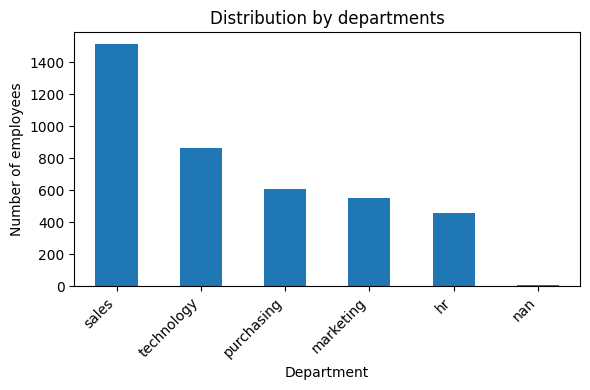

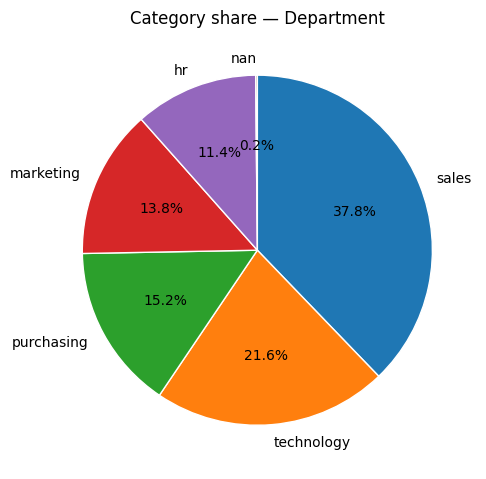


==== level ==== 

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object 



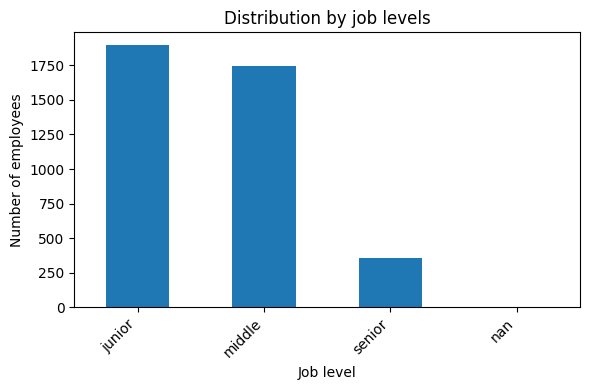

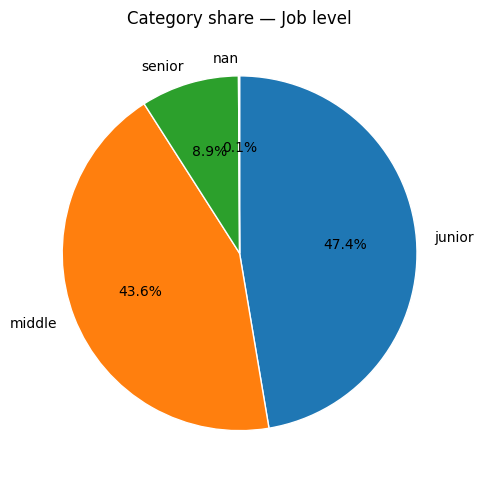


==== workload ==== 

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object 



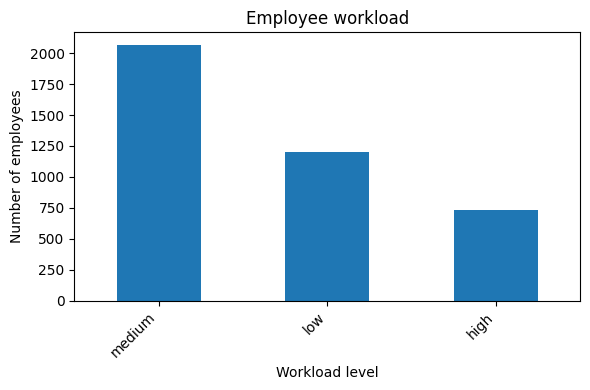

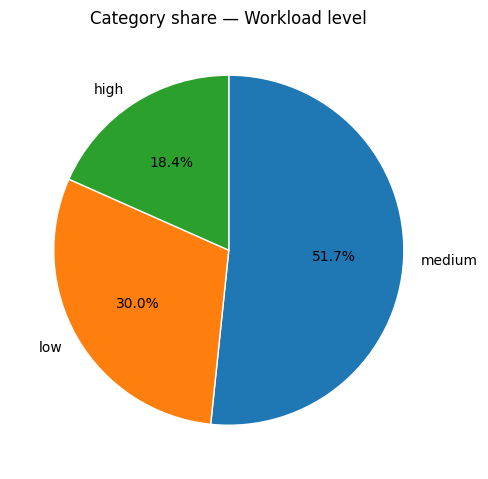


==== employment_years ==== 

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



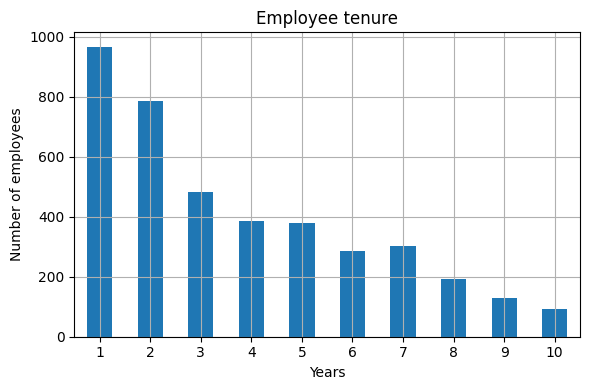


==== last_year_promo ==== 

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object 



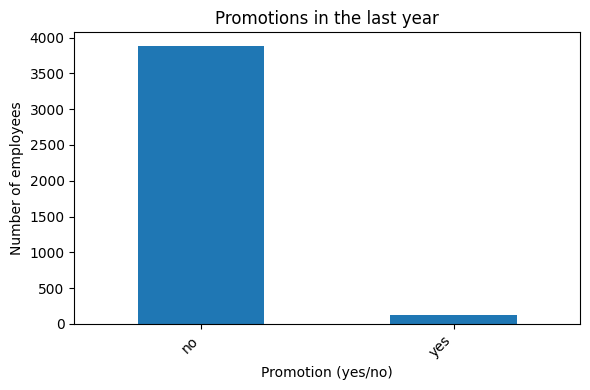

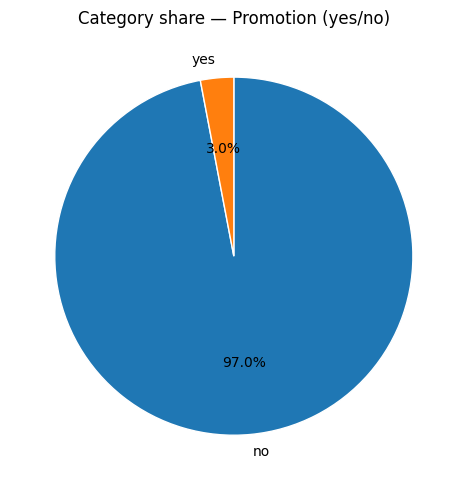


==== last_year_violations ==== 

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object 



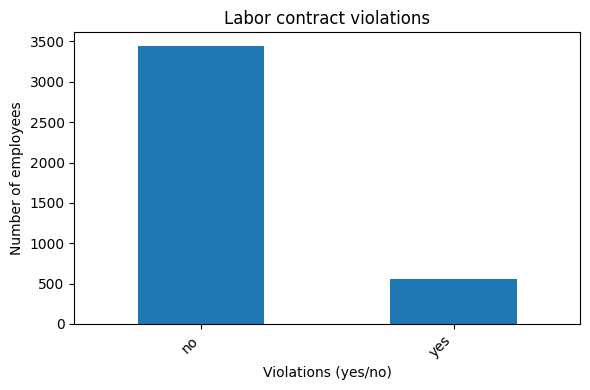

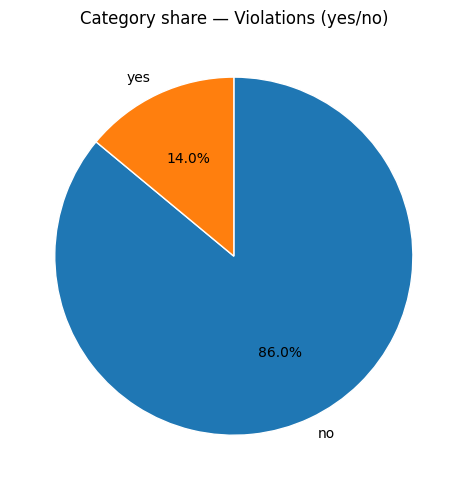


==== supervisor_evaluation ==== 

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



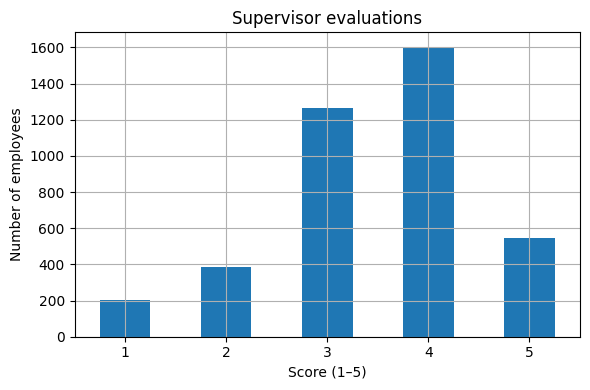


==== salary ==== 

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64 



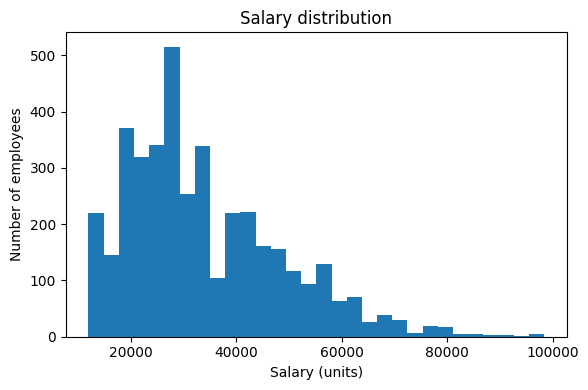

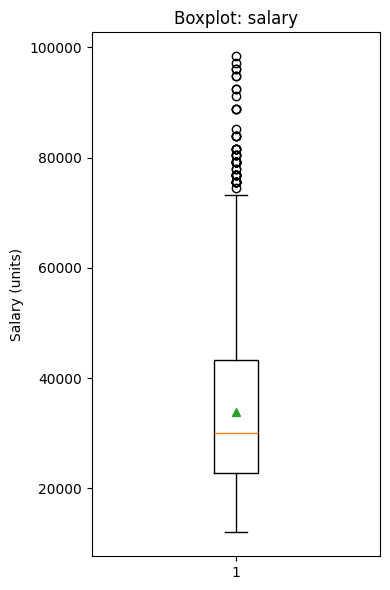


==== job_satisfaction_rate ==== 

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64 



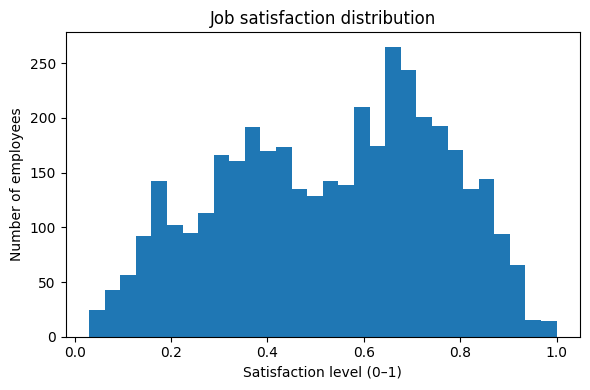

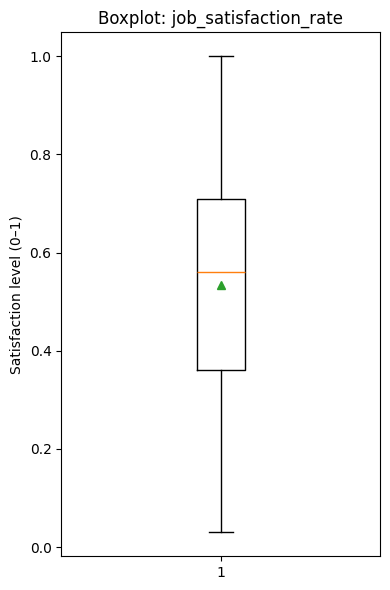

In [26]:
learn_data(train)


==== dept ==== 

count      1998
unique        5
top       sales
freq        764
Name: dept, dtype: object 



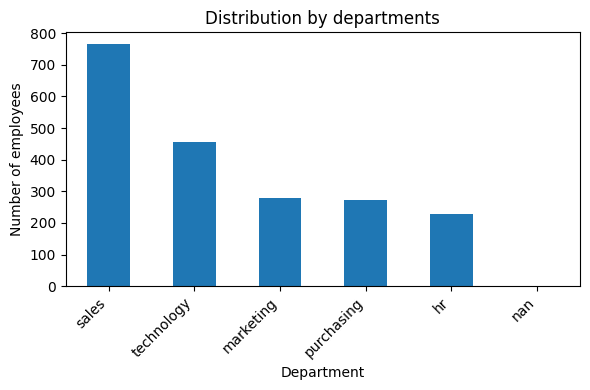

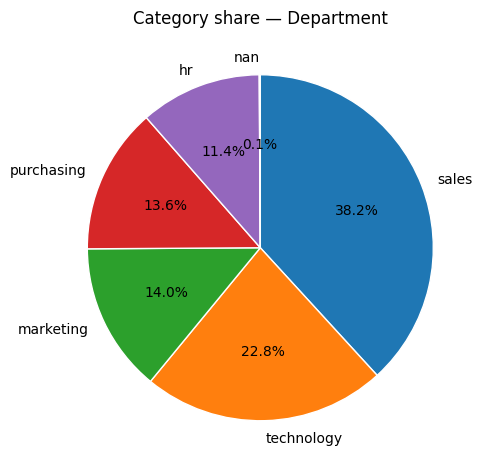


==== level ==== 

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object 



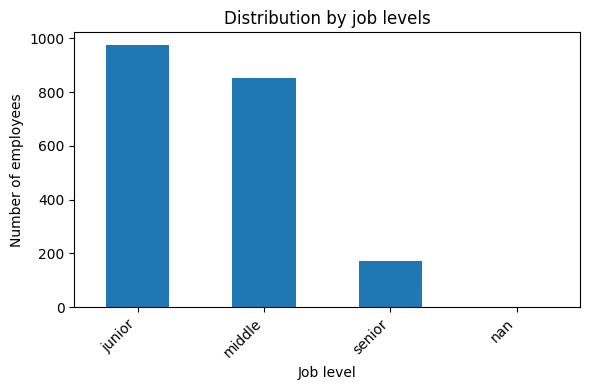

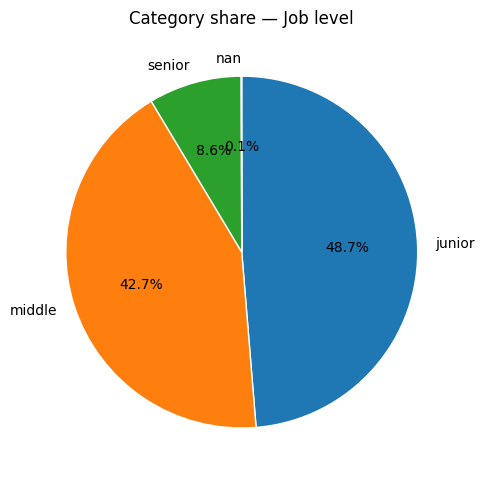


==== workload ==== 

count       2000
unique         3
top       medium
freq        1044
Name: workload, dtype: object 



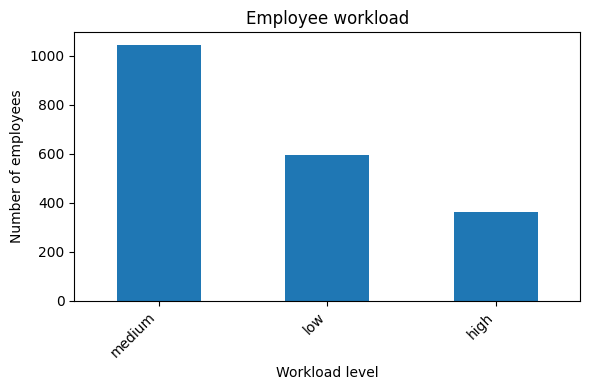

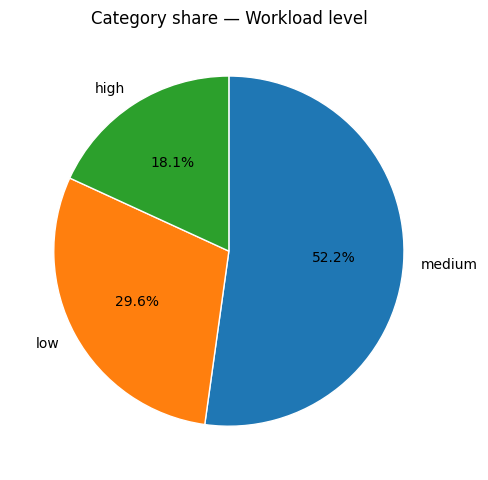


==== employment_years ==== 

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



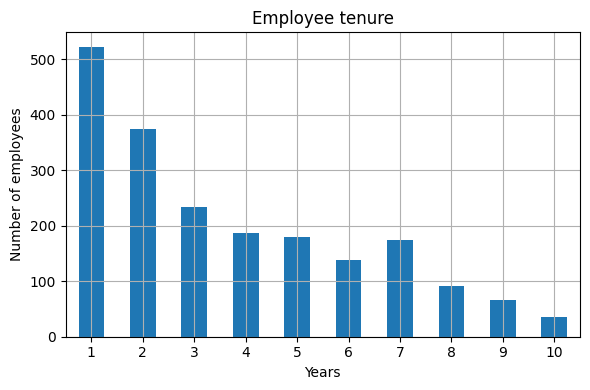


==== last_year_promo ==== 

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object 



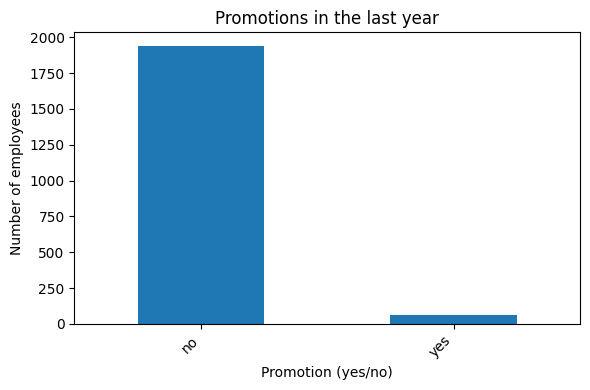

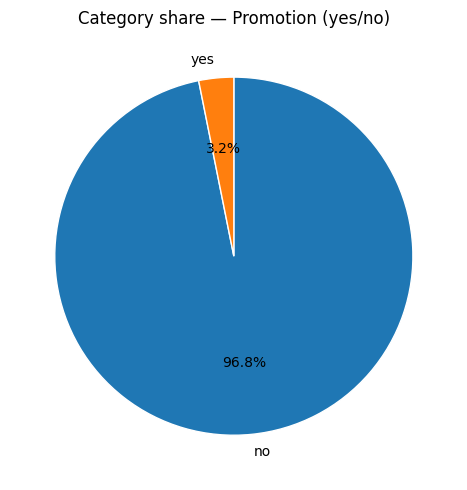


==== last_year_violations ==== 

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object 



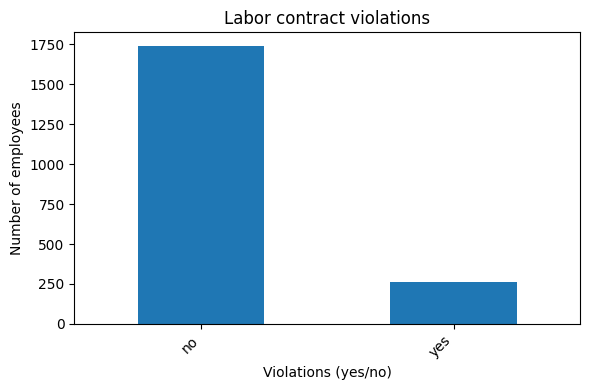

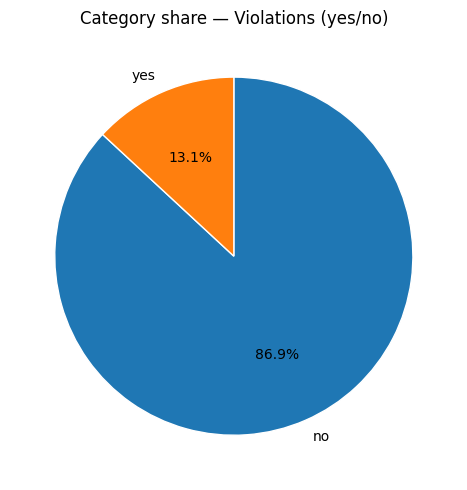


==== supervisor_evaluation ==== 

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



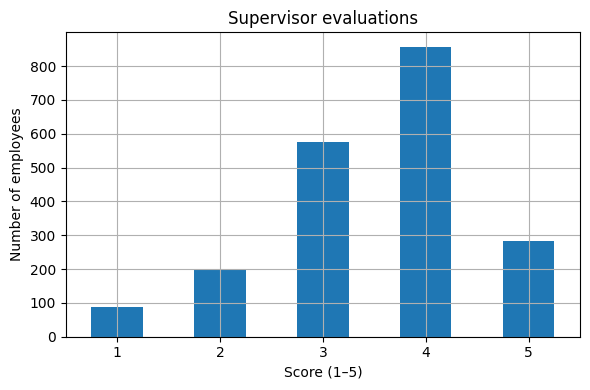


==== salary ==== 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



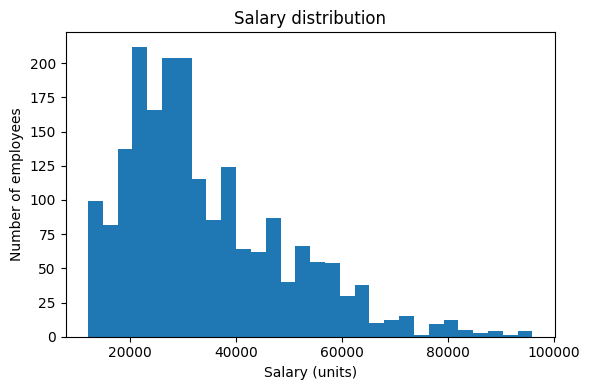

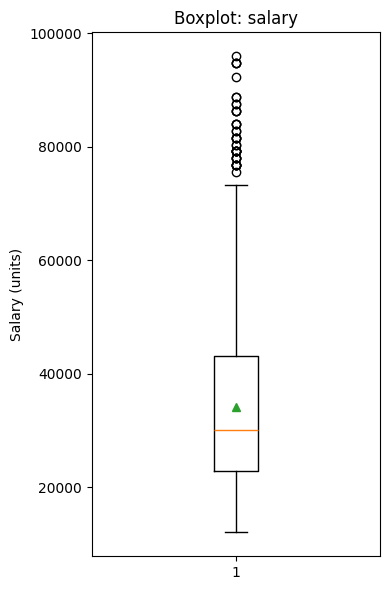

In [27]:
learn_data(test_features)


==== job_satisfaction_rate ==== 

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64 



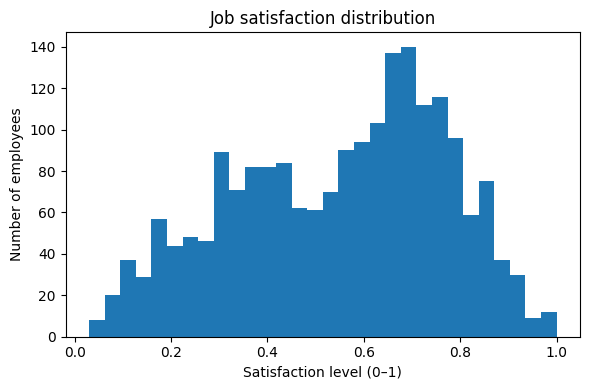

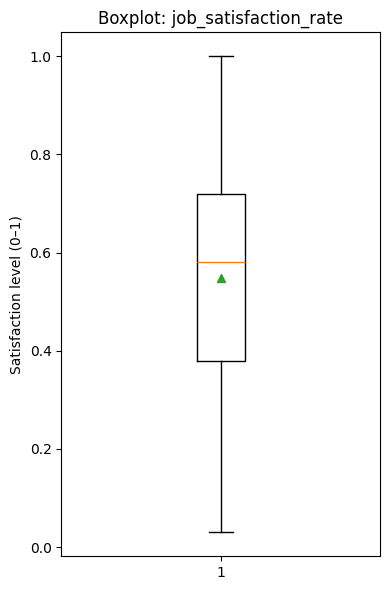

In [28]:
learn_data(test_target)

#### Summary Across the 3 Tables — Exploratory Data Analysis

Exploratory Data Analysis (EDA) made it possible to comprehensively examine the structure, quality, and distributions of the features.

**1. General characteristics of the datasets**

* **Categorical features:** `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations` — describe department, job level, workload, and behavioral characteristics of employees.

* **Discrete features:** `employment_years`, `supervisor_evaluation` — quantitative but integer-valued indicators.

* **Continuous features:** `salary`, `job_satisfaction_rate` — quantitative characteristics with possible fractional values.

---

**2. Statistical analysis of numerical features**

* **Tenure (`employment_years`)**

  * Range: from 1 to 10 years
  * Mean — **about 3.7 years**, median — **3 years**
  * The distribution is left-skewed, indicating a predominance of relatively junior employees with 1–3 years of tenure.

* **Supervisor evaluation (`supervisor_evaluation`)**

  * Range: from 1 to 5 points
  * Mean — **about 3.5**, median — **4**
  * Scores show low variability; most employees receive ratings of 3–4.

* **Salary (`salary`)**

  * Range: from 12,000 to 98,400 units
  * Mean — **about 34,000**, median — **30,000**, standard deviation — **about 15,000**
  * A substantial spread is observed, associated with job level and department.

* **Job satisfaction level (`job_satisfaction_rate`)**

  * Range: **0.03–1.00**
  * Mean — **0.5**, median — **about 0.56**, standard deviation — **about 0.22**
  * The distribution is close to normal, with a slight shift toward mid-range values.

**All numerical features were checked for outliers, and no significant anomalies were detected.**

---

**3. Analysis of categorical features**

* **Department (`dept`)**

  * The `sales` department accounts for more than **35% of employees**, making it the primary source of observations.
  * Other departments are distributed relatively evenly (10–20% per category).

* **Job level (`level`)**

  * `junior` — **≈48%**
  * `middle` — **≈43%**
  * `senior` — **≈9%**

  This aligns with the expected structure: the majority of employees are early-career specialists.

* **Workload (`workload`)**

  * `medium` — **≈52%**
  * `high` — **≈18%**
  * `low` — **≈30%**

  The bias toward medium workload indicates a generally balanced distribution of work intensity within the company.

* **Promotions and violations**

  * `last_year_promo = yes` — only **≈3% of employees**
  * `last_year_violations = yes` — **about 14%**

  These binary factors may potentially influence employee satisfaction and are therefore relevant for further analysis.


### Correlation Analysis <a id="correlation_analysis"></a>

#### Correlation matrix (Phik: numerical + categorical) for the training dataset

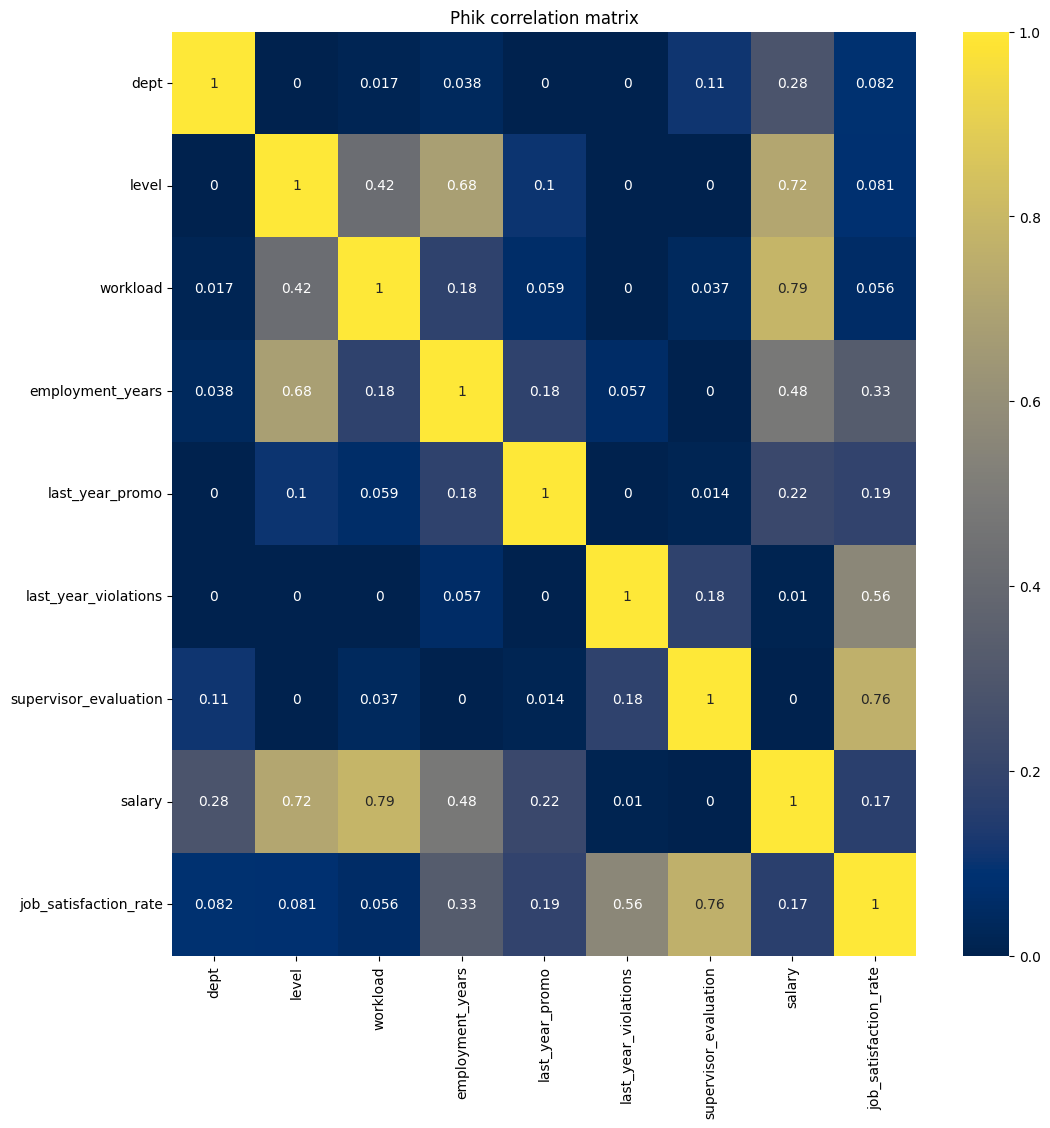

In [29]:
interval_cols = [c for c in continuous if c in train.columns]

phik_corr = train.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [30]:
phik_corr

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


#### Correlation matrix (Spearman)

****For numerical features, we will examine correlations using Spearman’s method****

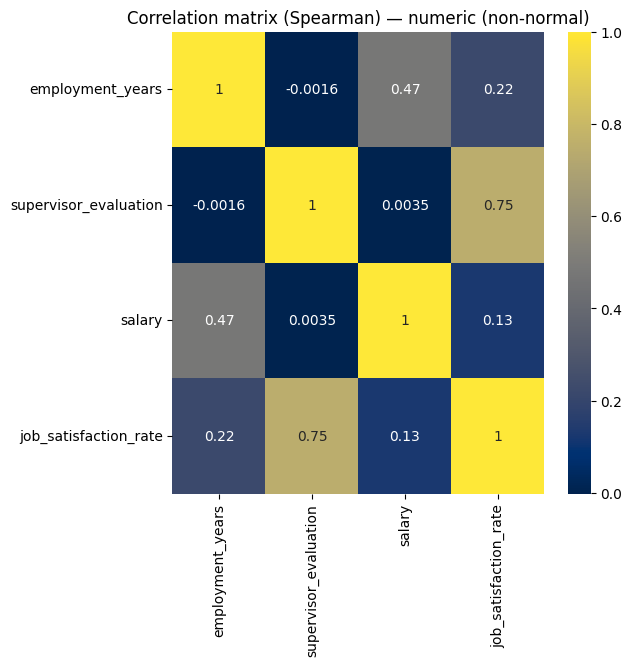

In [31]:
num_cols = train.select_dtypes(include='number').columns.tolist()
num_cols = [c for c in num_cols if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train[num_cols].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [32]:
train[num_cols].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,-0.001554,0.472688,0.218589
supervisor_evaluation,-0.001554,1.000000,0.003534,0.746608
salary,0.472688,0.003534,1.000000,0.126707
job_satisfaction_rate,0.218589,0.746608,0.126707,1.000000


#### Conclusions from the Correlation Analysis (Training Dataset)

****Numerical features (Spearman)****

* `supervisor_evaluation ↔ job_satisfaction_rate = 0.747` — a very strong relationship.

---

****Mixed / generalized features (Phik)****

**Relationship with the target `job_satisfaction_rate`:**

* **`supervisor_evaluation ↔ job_satisfaction_rate = 0.764`** — the strongest predictor of satisfaction.
* **`last_year_violations ↔ job_satisfaction_rate = 0.560`** — a strong negative association: violations significantly reduce satisfaction.
* **`dept ↔ job_satisfaction_rate = 0.082`**, **`level ↔ job_satisfaction_rate = 0.081`**, **`workload ↔ job_satisfaction_rate = 0.056`** — weak relationships.

**Relationships between predictors:**

* **`salary`** is strongly associated with:

  * `workload = 0.789`
  * `level = 0.718`
  * `employment_years = 0.483`
* **`level ↔ employment_years = 0.683`** — a pronounced link between hierarchy and tenure.

---

****Implications for modeling****

* **Key drivers:**

  * Across numerical and mixed metrics: `supervisor_evaluation` (**Phik = 0.764**)
  * Behavioral/disciplinary factor: `last_year_violations` (**0.560**)

* **Multicollinearity:**

  * Among numerical predictors, there is no clear linear multicollinearity (per Spearman).

  * Phik values of **0.79 (salary ↔ workload)** and **0.72 (salary ↔ level)** indicate strong associations and informational redundancy between `salary` and the categorical variables `workload` and `level`.
    Although Phik is not a linear metric, such magnitudes warn about potential multicollinearity after categorical encoding (One-Hot / Ordinal): strong associations may translate into linear dependencies between the numeric `salary` column and encoded dummy/ordinal columns.

  * **Recommended actions:**

    * For linear models: apply **regularization (L1/L2)** or **feature selection**.
    * For tree-based models: this is generally tolerable.
    * Consider **interaction features**: `level × workload`, `employment_years × level`.
    * When using One-Hot Encoding, apply `drop='first'`.

---

****Practical HR takeaway****

The strongest impact on job satisfaction comes from performance quality and supervisor evaluation, as well as discipline. Compensation (salary) plays a secondary role and is largely mediated by job level and workload.


#### Correlation Matrix (Phik: Numerical + Categorical) for the Test Dataset

In [33]:
# Merging test_features (feature columns) and test_target (target column)
test_merged = test_features.merge(test_target, on='id')

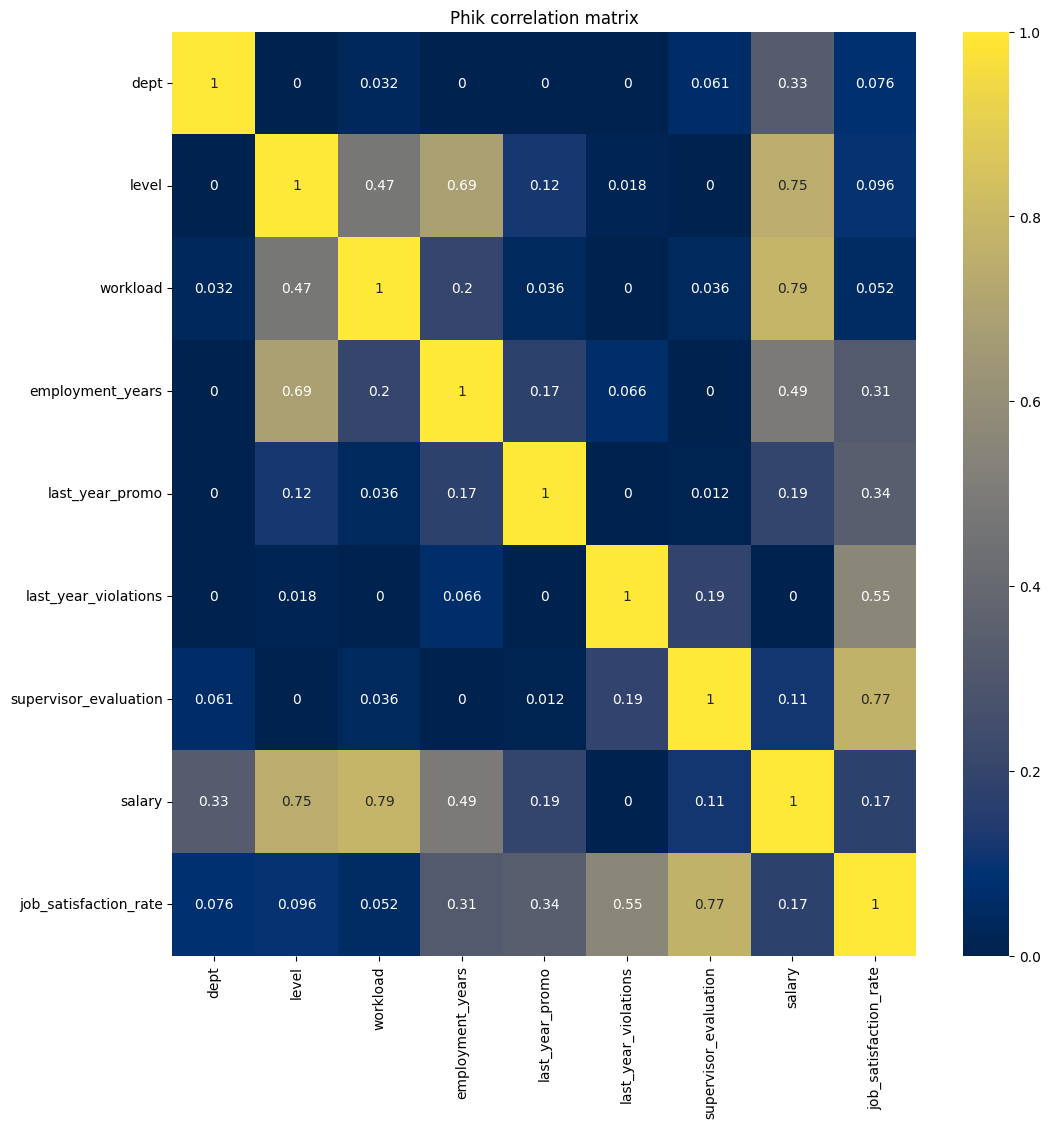

In [34]:
# phik
interval_cols_test = [c for c in continuous if c in test_merged.columns]

phik_corr_test = test_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [35]:
phik_corr_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.075762
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.095706
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.052157
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903
job_satisfaction_rate,0.075762,0.095706,0.052157,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000


#### Correlation matrix (Spearman)

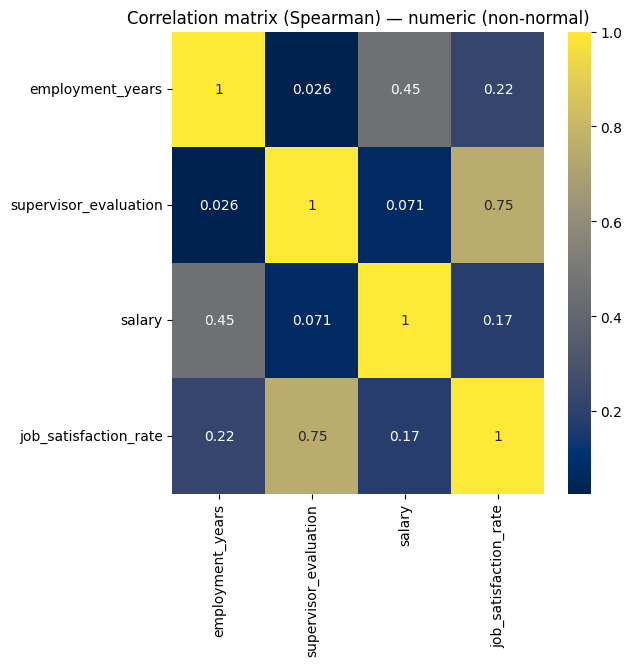

In [36]:
num_cols_test = test_merged.select_dtypes(include='number').columns.tolist()
num_cols_test = [c for c in num_cols_test if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_merged[num_cols_test].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [37]:
test_merged[num_cols].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
employment_years,1.000000,0.026278,0.452343,0.223898
supervisor_evaluation,0.026278,1.000000,0.071399,0.749670
salary,0.452343,0.071399,1.000000,0.174644
job_satisfaction_rate,0.223898,0.749670,0.174644,1.000000


#### Conclusions from the Correlation Analysis (Test Dataset)

* No significant discrepancies were found between the training and test datasets in terms of dependency structure.

* Using the test dataset to evaluate model performance is appropriate: the patterns of relationships and the relative strengths of predictors are consistent with those observed in the training dataset.

* Therefore, model quality metrics (ROC-AUC, SMAPE) can be compared and interpreted on the test set without the risk of systematic bias caused by data differences.


### Using Pipelines <a id="using_pipelines"></a>

#### Model Evaluation Metric: **SMAPE**

****SMAPE is wrapped with `make_scorer(..., greater_is_better=False)` and is used in all hyperparameter tuning procedures as well as in the final evaluation.****

In [38]:
def smape(y_true, y_pred):
    """
    Computes the Symmetric Mean Absolute Percentage Error (SMAPE)

    Parameters:
    y_true : array-like (NumPy array or pandas.Series)
        True target values.
    y_pred : array-like (NumPy array or pandas.Series)
        Predicted target values.

    Returns:
    float
        SMAPE value in percent.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)

    # Avoid division by zero
    mask = denominator != 0
    smape_value = np.mean(diff[mask] / denominator[mask]) * 100

    return smape_value


scorer = make_scorer(smape, greater_is_better=False)


#### Data Preparation

* A single **ColumnTransformer** is used.

* **OneHotEncoder** for nominal features (`dept`) with `drop='first'`.

* **OrdinalEncoder** for ordered categorical features (`level`, `workload`, `last_year_promo`, `last_year_violations`) with a predefined class order; mode imputation is applied before and after encoding to ensure robustness to missing/unseen categories.

* **Numerical features** (`employment_years`, `supervisor_evaluation`, `salary`) use median imputation and scaling (**StandardScaler / MinMaxScaler / passthrough**, selected via cross-validation).

****Train–test split****

* **X_train** — all columns except `id` and `job_satisfaction_rate`.

* **y_train** — `job_satisfaction_rate`.

* **Test set:** `test_features` and `test_target` are merged by `id` (with synchronized indices), which eliminates row misalignment and prevents leakage or ordering bias.

****Remove `id` and count duplicates****

In [39]:
train.drop(columns=['id']).duplicated().sum()

np.int64(245)

__Removing duplicates__

In [40]:
train_no_id = train.drop(columns=['id']).drop_duplicates(keep='first')

In [41]:
print(f"Size before: {train.drop(columns=['id']).shape}, after: {train_no_id.shape}")

Size before: (4000, 9), after: (3755, 9)


In [42]:
X_train = train_no_id.drop(columns=['job_satisfaction_rate'])
y_train = train_no_id['job_satisfaction_rate']

****Result****

* **245 full duplicates** were detected and removed.

* The size of the training dataset decreased from **4,000 → 3,755 rows**, improving data cleanliness.

* The split into **X_train** and **y_train** was performed **after deduplication**, ensuring that indices are properly synchronized.

* Deduplication was applied **only to the training set**, since the test dataset is not modified (it simulates a real production data flow).


In [43]:
X_test = test_features.set_index('id').sort_index()
y_test = (test_target
          .set_index('id')
          .sort_index()['job_satisfaction_rate']) 

print("Dataset shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# feature lists
# OHE: nominal category without order
ohe_columns = ['dept']

# Ordinal: ordered categories
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

# Numeric features (excluding target and id)
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# encoding / imputation pipelines
ohe_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


Dataset shapes:
X_train: (3755, 8)
X_test: (2000, 8)
y_train: (3755,)
y_test: (2000,)


In [44]:
# category order
ord_categories = [
    ['junior', 'middle', 'senior'],   # level
    ['low', 'medium', 'high'],        # workload
    ['no', 'yes'],                    # last_year_promo
    ['no', 'yes']                     # last_year_violations
]

ord_pipe = Pipeline(steps=[
    ('impute_before', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=ord_categories,
        handle_unknown='use_encoded_value',
        unknown_value=np.nan
    )),
    ('impute_after', SimpleImputer(strategy='most_frequent'))
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# overall preprocessor
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns),
    ],
    remainder='drop'
)


#### Hyperparameter Tuning and Final Models


##### Decision Tree Regressor

* **Overall pipeline:** `preprocessor + DecisionTreeRegressor`.

* **RandomizedSearchCV** (`cv=5`, `scoring=SMAPE`, `n_iter=35`, `n_jobs=-1`) tunes:

  * tree depth (`max_depth`),
  * minimum samples for split and leaf,
  * the numeric scaling type (via `preprocessor__num__scale`).


In [45]:
# final pipeline: preprocessor + regressor
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# parameter grid for the decision tree
param_distributions = {
    'model__max_depth': range(2, 25),
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(2, 10),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_iter=35,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print("Best parameters:", randomized_search.best_params_)
print("Best SMAPE (%):", -randomized_search.best_score_)


Best parameters: {'preprocessor__num__scale': 'passthrough', 'model__min_samples_split': 8, 'model__min_samples_leaf': 2, 'model__max_depth': 18}
Best SMAPE (%): 15.136823481314682


**Ridge Regression (a linear model with L2 regularization)**

* **Pipeline:** preprocessor + Ridge.

* **GridSearchCV** (cv=5, scoring=SMAPE) tunes **alpha** and the type of **numerical scaler**.

In [46]:
pipe_ridge = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', Ridge(random_state=RANDOM_STATE))
])

param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 3, 10, 30, 100],
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler()]  
}

grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring=scorer,   # your SMAPE
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

print("Best parameters (Ridge):", grid_ridge.best_params_)
print("Best CV SMAPE (Ridge, %):", -grid_ridge.best_score_)

Best parameters (Ridge): {'model__alpha': 3, 'preprocessor__num__scale': StandardScaler()}
Best CV SMAPE (Ridge, %): 24.993007320981338


****Conclusion.****

The linear model performs noticeably worse than the tree-based model: the data structure contains nonlinearities and feature interactions that Ridge cannot capture, even with well-encoded categorical variables.

#### Evaluation on the test set and conclusion

After comparative cross-validation analysis, the **Decision Tree Regressor** was selected for final evaluation on the test set as the best-performing model according to **SMAPE**.

In [47]:
best_model = randomized_search.best_estimator_
y_pred_test = best_model.predict(X_test)
print("Test SMAPE (%):", smape(y_test, y_pred_test))

Test SMAPE (%): 13.348457861146008


****Results:****

CV SMAPE (%): 15.1

Test SMAPE (%): 13.35

****Final conclusion:****

**SMAPE leader:** Decision Tree Regressor (CV ≈ 15.1%, Test ≈ 13.35%).

**Ridge Regression** delivered a stable but inferior result (CV ≈ 24.99%), confirming the presence of pronounced nonlinear relationships in the data.

****Why the tree performs better in this task****

* **Nonlinearity:** the tree captures threshold effects and interactions between categorical and numerical features
* **Robustness:** low sensitivity to feature scaling and outliers
* **Complexity control:** optimal `max_depth`, `min_samples_split`, and `min_samples_leaf` limit overfitting

****Conclusion:****

The **Decision Tree Regressor** successfully passed the test against the success criterion (SMAPE ≤ 15%) and can be recommended as the primary model for predicting employee satisfaction levels.


In [48]:
# Baseline model — predicts the mean value of the target variable
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

# Predictions from the Dummy model
y_pred_dummy = dummy.predict(X_test)

# Compute SMAPE for DummyRegressor and the best model
dummy_smape = smape(y_test, y_pred_dummy)
best_smape = smape(y_test, best_model.predict(X_test))

print(f'SMAPE DummyRegressor: {dummy_smape:.3f}%')
print(f'SMAPE of the best model (DecisionTreeRegressor): {best_smape:.3f}%')
print(f'Improvement over baseline: {dummy_smape - best_smape:.3f}%')


SMAPE DummyRegressor: 38.262%
SMAPE of the best model (DecisionTreeRegressor): 13.348%
Improvement over baseline: 24.914%


### Conclusion and Key Findings <a id="conclusion_findings"></a>

During the project, a full data analysis and predictive modeling cycle was completed to estimate employee satisfaction levels (**job_satisfaction_rate**) based on internal HR metrics. The work included exploratory data analysis, missing value handling, feature engineering, categorical encoding, and model evaluation using a custom quality metric — **SMAPE (Symmetric Mean Absolute Percentage Error)**.

#### Key results:

1. **Data quality.**
   The dataset was cleaned and preprocessed: duplicates and missing values were handled, categories were standardized (e.g., correcting the typo *sinior → senior*), and variables were encoded according to their types (One-Hot and Ordinal encoding). All features were classified as categorical, discrete, or continuous, enabling correct analysis and model construction.

2. **Correlation analysis.**
   Spearman and Phik metrics were used to identify relationships:

   * The strongest association with the target variable was observed for **supervisor_evaluation (ρ = 0.75, Phik = 0.76)**.
   * A strong negative relationship was found for **last_year_violations (Phik = 0.56)** — disciplinary violations reduce satisfaction.
   * Interdependencies were observed among `salary`, `level`, and `workload`, indicating structural relationships in the data rather than a direct impact on satisfaction.

3. **Pipeline construction and model selection.**
   A unified `Pipeline` with `ColumnTransformer` was applied, combining:

   * missing value imputation,
   * categorical encoding (OHE, OrdinalEncoder),
   * numerical feature scaling.
     This standardized data preparation and prevented data leakage during cross-validation.

4. **Model evaluation and results:**

   * **DecisionTreeRegressor** achieved the best performance after hyperparameter tuning:

     * CV SMAPE = **15.1%**
     * Test SMAPE = **13.35%**
   * **Ridge Regression** showed inferior performance (CV SMAPE = **24.99%**), confirming the nonlinear nature of relationships between features.

   Overall, the decision tree proved to be the most suitable tool for this task due to its ability to model complex nonlinear dependencies.

5. **Practical insights.**

   * The key driver of satisfaction is **manager evaluation**, highlighting the critical role of managerial feedback.
   * The second most influential factor is **discipline**: violations significantly reduce satisfaction levels.
   * Salary and tenure have an indirect impact through job level and workload.
   * For HR analytics, the results can be used to build internal satisfaction monitoring systems and to identify “at-risk” employee groups early.

#### Final summary:

A decision tree model with optimized depth and minimum leaf size demonstrated the **best balance between accuracy and interpretability** (Test SMAPE ≈ **13.35%**). This means that predictions deviate from actual values by less than 14% on average, which can be considered **high performance** for behavioral HR metrics.


## Task 2: Predicting Employee Attrition <a id="task_2"></a>


### Data loading <a id="data_loading_2"></a>


In [49]:
# Load the datasets
train_quit = pd.read_csv('../data/train_quit.csv')
test_target_quit = pd.read_csv('../data/test_target_quit.csv')

****The input features of the test set are the same as in the previous task:****

* `test_features`


### Data preprocessing <a id="data_preprocessing_2"></a>


#### Extracting the required features — Training set


In [50]:
look_data(train_quit)

------------- Original DataFrame (first 5 rows) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

------------- Number of missing values in the DataFrame -------------




id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Checking unique values of non-numeric columns -------------


Column: dept
Number of unique values: 5
Unique values: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
------------------------------------------------------------
Column: level
Number of unique values: 3
Unique values: ['middle' 'junior' 'sinior']
------------------------------------------------------------
Column: workload
Number of unique values: 3
Unique values: ['high' 'medium' 'low']
------------------------------------------------------------
Column: last_year_promo
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------
Column: last_year_violations
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------
Column: quit
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------


##### Brief summary of the **Training set** data

**Size, types, target**
4,000 rows × 10 columns.
Types: 6 object, 4 int.
Target variable — `quit` (binary: `yes`/`no`), with no missing values.

**Missing values and duplicates**
No missing values in any column.
Number of duplicate rows — 0.

**Categorical features (unique values)**

* `dept`: 5 categories — ['sales', 'purchasing', 'marketing', 'technology', 'hr'].
* `level`: 3 categories — ['middle', 'junior', **'sinior'**] → typo detected (**should be replaced with `senior`**).
* `workload`: 3 categories — ['high', 'medium', 'low'].
* `last_year_promo`, `last_year_violations`, `quit`: binary — ['no', 'yes'].

**Numerical features — key statistics**

* `employment_years`: min=1, Q1=2, median=3, mean≈3.70, Q3=6, max=10.
* `supervisor_evaluation`: range 1–5, median=4, mean≈3.47.
* `salary`: min=12,000, Q1=22,800, median=30,000, Q3=43,200, max=96,000, mean≈33,806.

**Implications for preprocessing**

* Fix the typo in `level`: **'sinior' → 'senior'**.
* Encode categorical variables (One-Hot / Ordinal) and scale numerical features if needed (especially **salary**).


##### Fixing the typo in `level`: `'sinior' → 'senior'`


In [51]:
train_quit.loc[:, 'level'] = train_quit['level'].replace('sinior', 'senior')

Verification

In [52]:
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

#### Extracting the required features — Test set input features


In [53]:
look_data(test_features)

------------- Original DataFrame (first 5 rows) -------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

------------- Number of missing values in the DataFrame -------------




id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


------------- Checking unique values of non-numeric columns -------------


Column: dept
Number of unique values: 6
Unique values: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
------------------------------------------------------------
Column: level
Number of unique values: 4
Unique values: ['junior' 'middle' 'senior' nan]
------------------------------------------------------------
Column: workload
Number of unique values: 3
Unique values: ['medium' 'low' 'high']
------------------------------------------------------------
Column: last_year_promo
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------
Column: last_year_violations
Number of unique values: 2
Unique values: ['no' 'yes']
------------------------------------------------------------


##### Brief summary of the **Test set input features**

**Size, types, structure**
2,000 rows × 9 columns.
Types: 5 object, 4 int.
No target variable — features only.

**Missing values and duplicates**
No missing values in any column.
Number of duplicate rows — 0.

**Categorical features (unique values)**

* `dept`: 5 categories — ['marketing', 'hr', 'sales', 'purchasing', 'technology'].
* `level`: 3 categories — ['junior', 'middle', 'senior'] (typos fixed).
* `workload`: 3 categories — ['medium', 'low', 'high'].
* `last_year_promo`, `last_year_violations`: binary — ['no', 'yes'].

**Numerical features — key statistics**

* `employment_years`: 1–10; Q1=1, median=3, Q3=6, mean≈3.67.
* `supervisor_evaluation`: 1–5; median=4, mean≈3.53.
* `salary`: 12,000–96,000; Q1=22,800, median=30,000, Q3=43,200, mean≈34,067.

**Implications for preprocessing**

* The test feature data are fully clean (no NaNs or spurious categories).


#### Extracting the required features — Test set target variable


In [54]:
look_data(test_target_quit)

------------- Original DataFrame (first 5 rows) -------------


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes





------------- General DataFrame information -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

------------- Number of missing values in the DataFrame -------------




id      0
quit    0
dtype: int64

------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)




------------- Descriptive statistics -------------


,quit
count,2000
unique,2
top,no
freq,1436


------------- Checking unique values of non-numeric columns -------------


Column: quit
Number of unique values: 2
Unique values: ['yes' 'no']
------------------------------------------------------------


##### Brief summary of the **Test set target variable (`quit`)**

**Size and structure**
2,000 rows × 2 columns (`id`, `quit`).
Types: `id` — int, `quit` — object (binary variable: `yes`/`no`).

**Missing values and duplicates**
No missing values.
Number of duplicates — 0.

**Target variable**

* `quit`: 2 categories — ['yes', 'no'] (class balance should be examined via the distribution; no obvious data quality issues).

**Implications for validation**

* The test target is fully ready for use.


### Exploratory Data Analysis <a id="exploratory_data_analysis_2"></a>



==== dept ==== 

count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object 



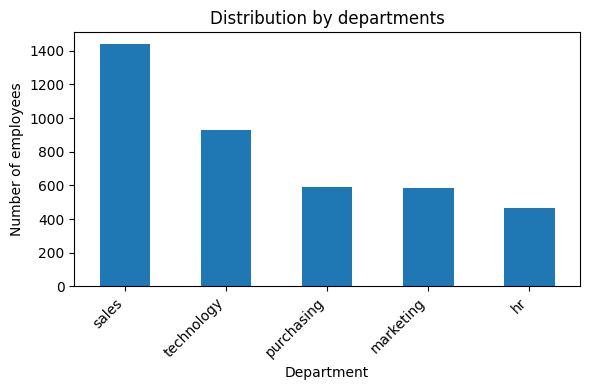

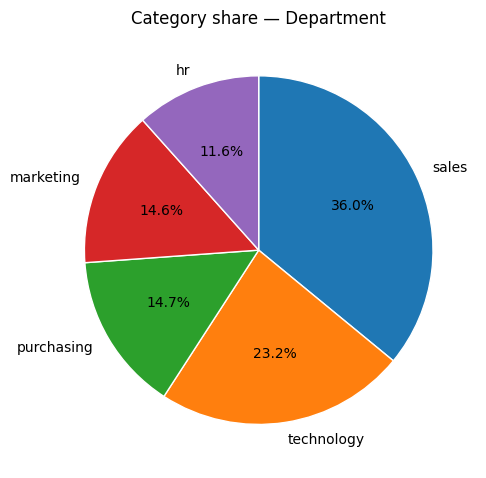


==== level ==== 

count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object 



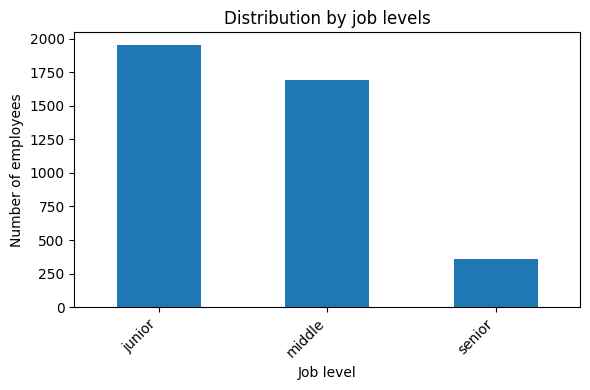

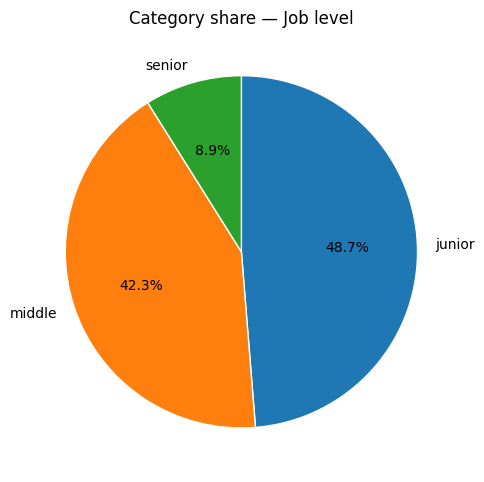


==== workload ==== 

count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object 



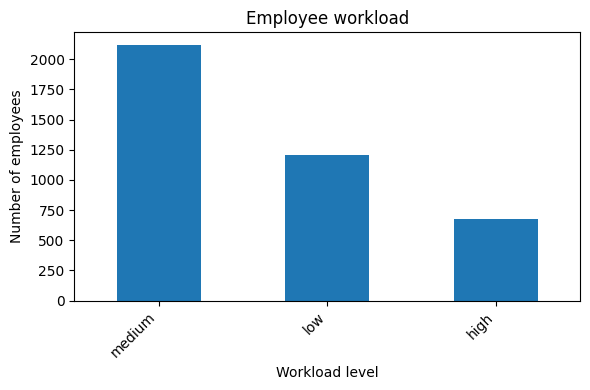

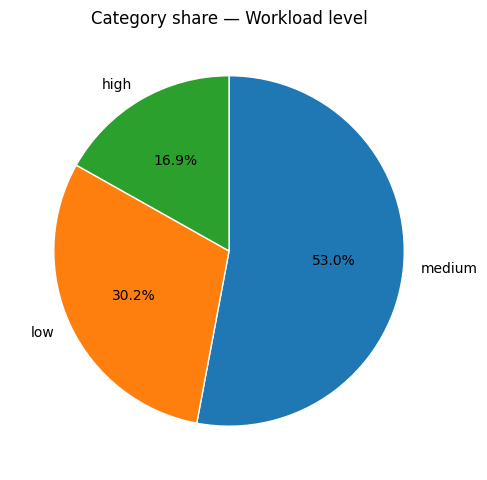


==== employment_years ==== 

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



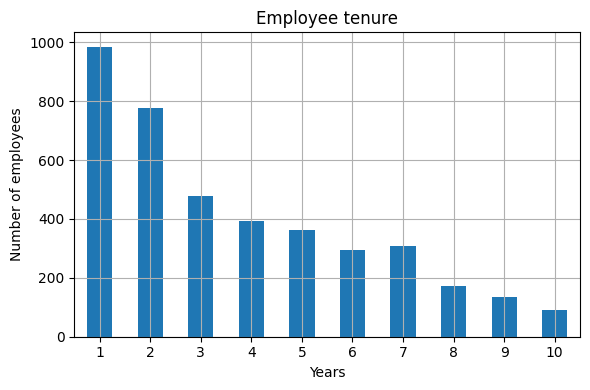


==== last_year_promo ==== 

count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object 



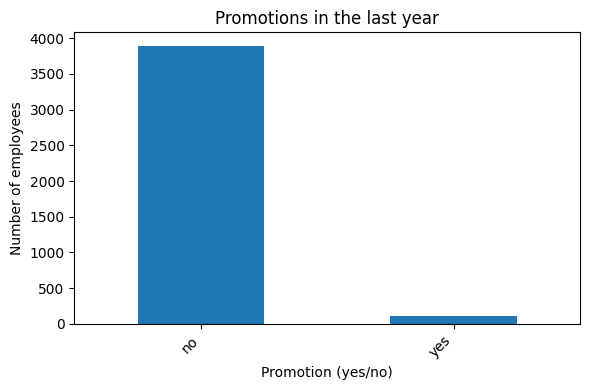

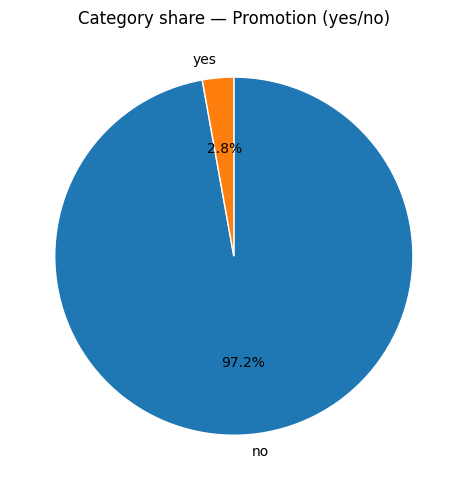


==== last_year_violations ==== 

count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object 



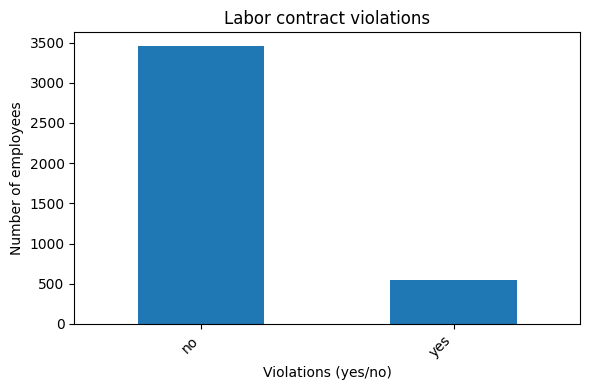

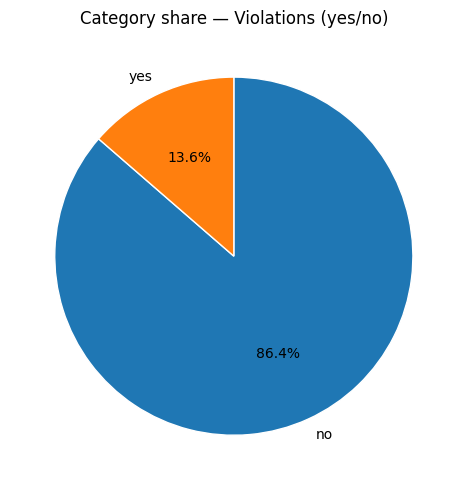


==== supervisor_evaluation ==== 

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



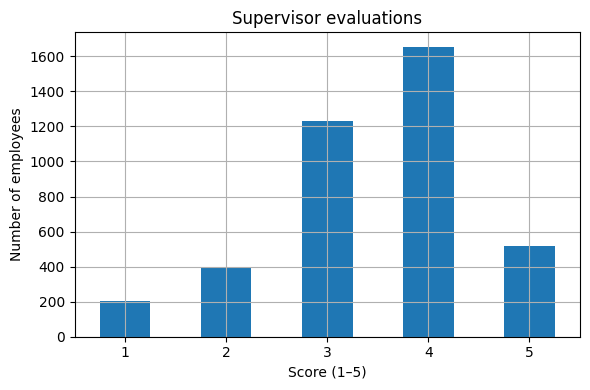


==== salary ==== 

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



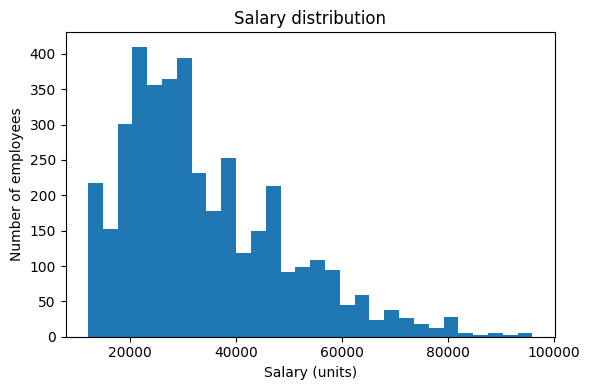

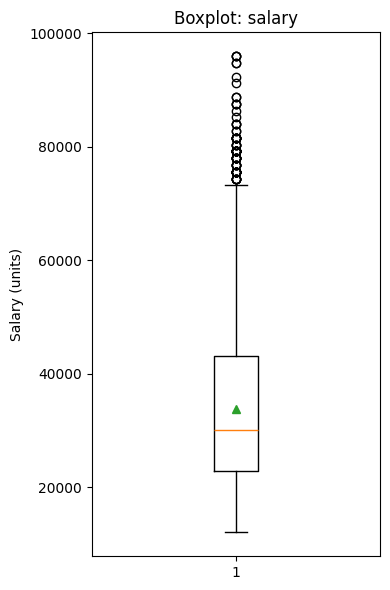


==== quit ==== 

count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object 



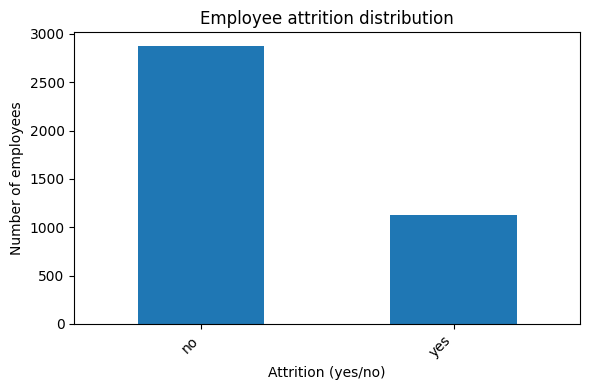

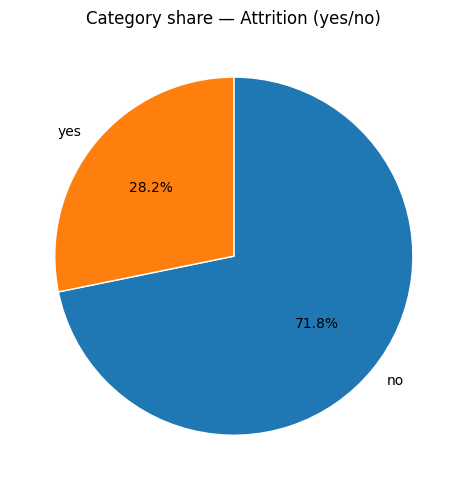

In [55]:
learn_data(train_quit)


==== dept ==== 

count      1998
unique        5
top       sales
freq        764
Name: dept, dtype: object 



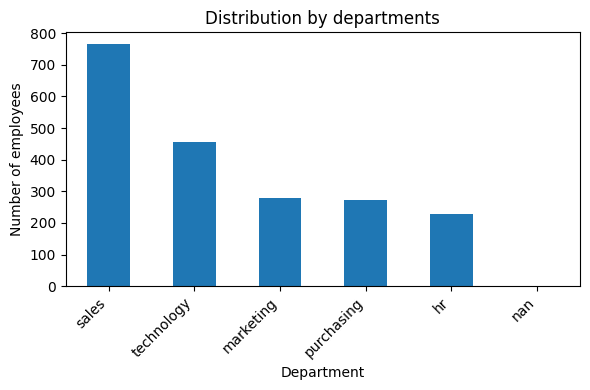

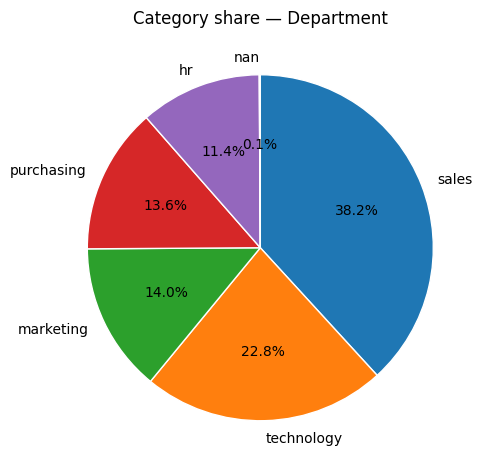


==== level ==== 

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object 



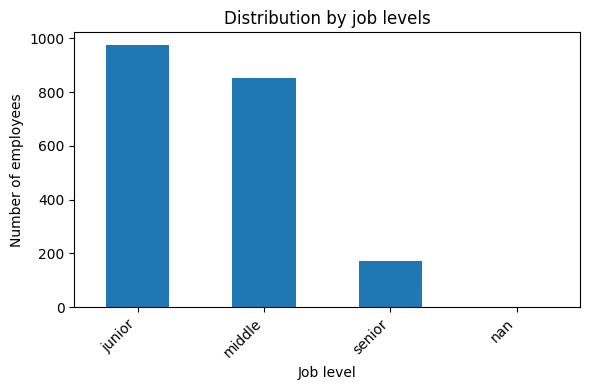

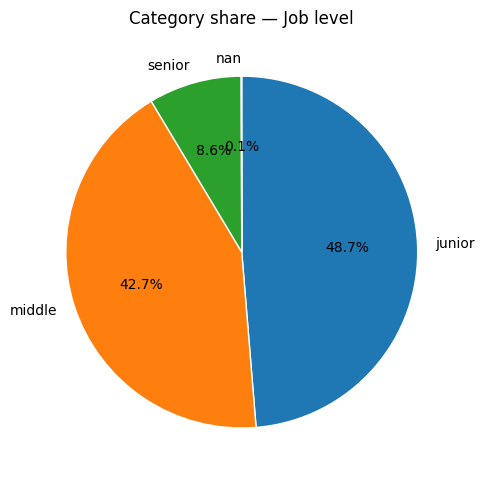


==== workload ==== 

count       2000
unique         3
top       medium
freq        1044
Name: workload, dtype: object 



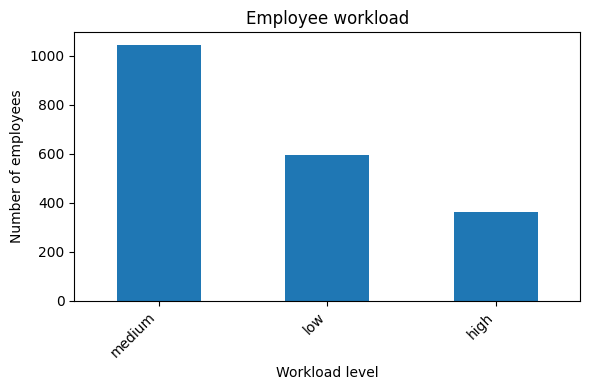

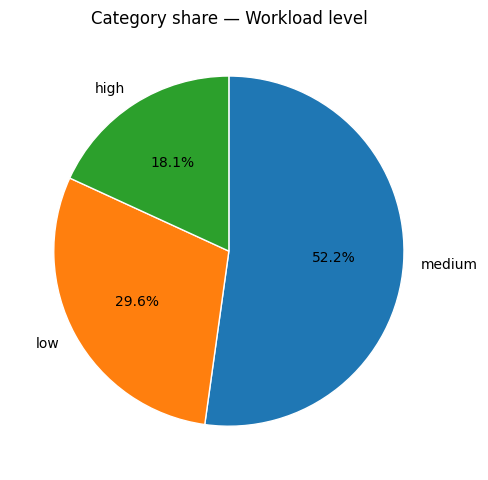


==== employment_years ==== 

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64 



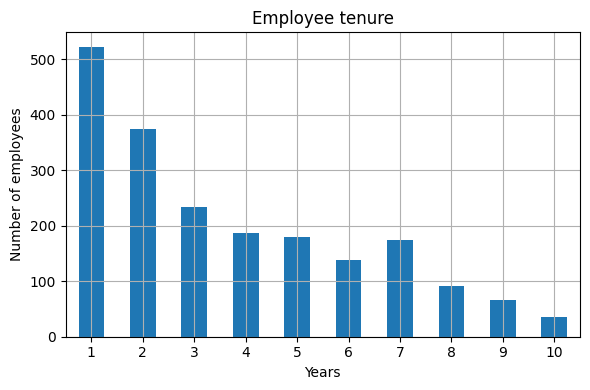


==== last_year_promo ==== 

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object 



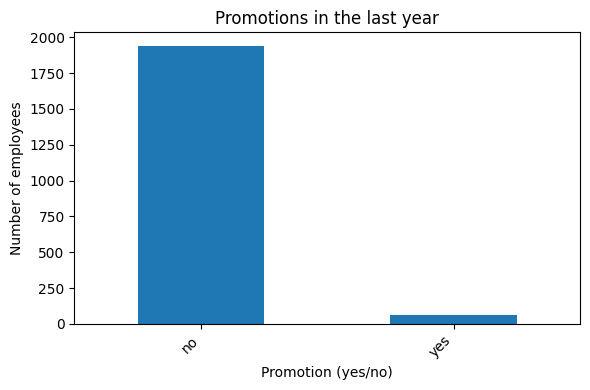

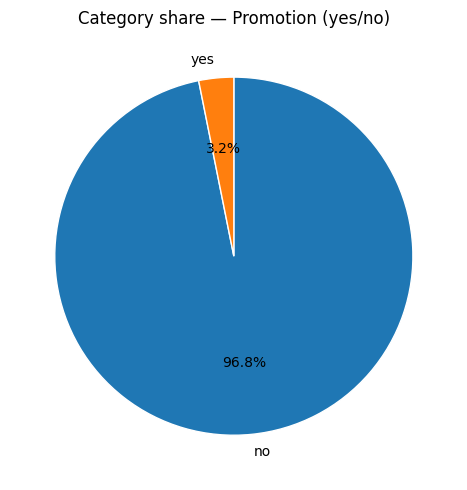


==== last_year_violations ==== 

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object 



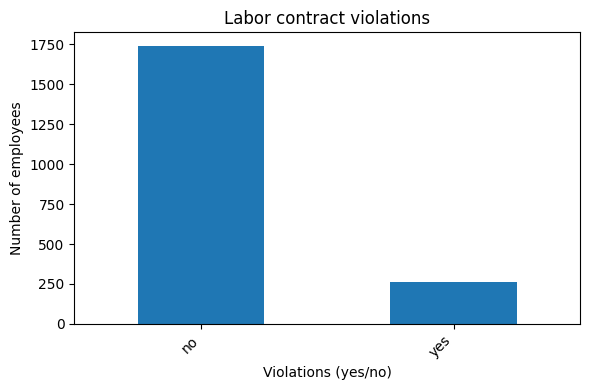

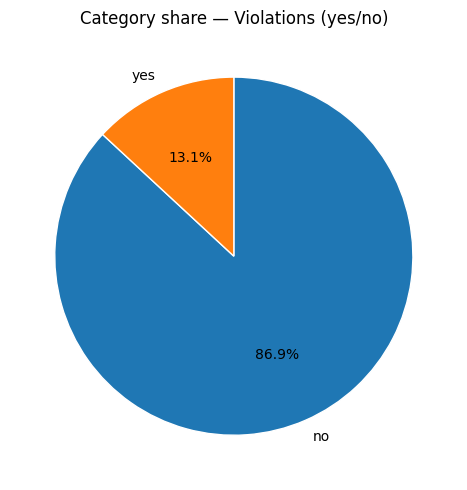


==== supervisor_evaluation ==== 

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64 



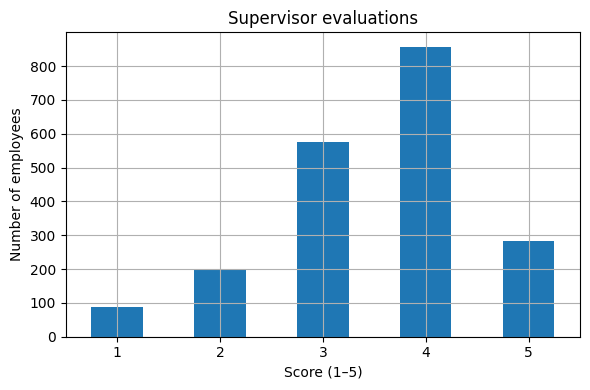


==== salary ==== 

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



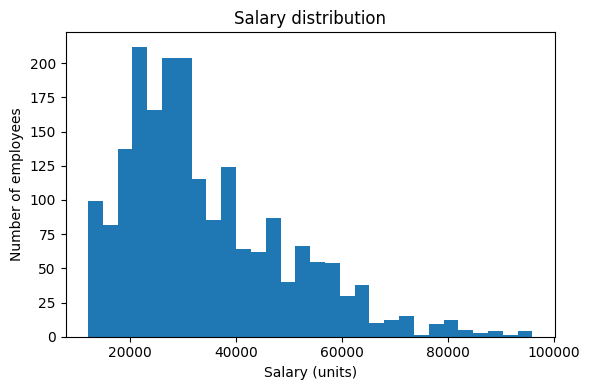

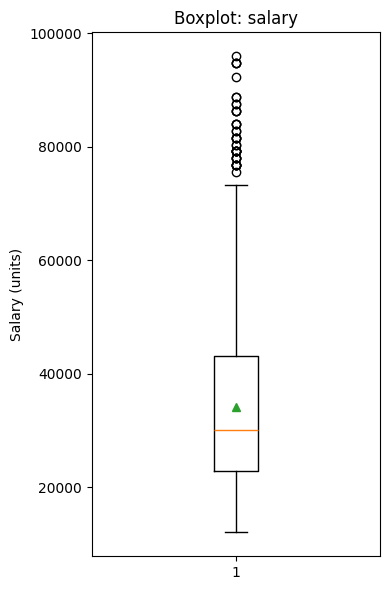

In [56]:
learn_data(test_features)


==== quit ==== 

count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object 



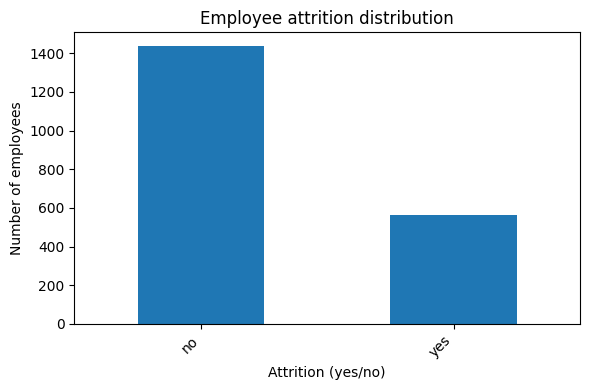

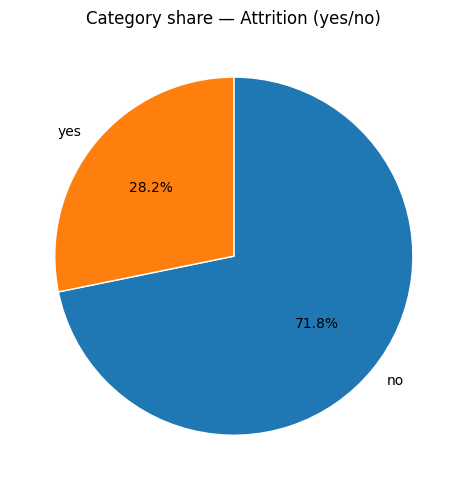

In [57]:
learn_data(test_target_quit)

#### Summary of the three tables — Exploratory Data Analysis

The exploratory data analysis made it possible to comprehensively examine the structure, quality, and feature distributions across all three datasets: **train_quit**, **test_features**, and **test_target_quit**.

---

**1. General characteristics of the datasets**

* **Training set (train_quit)** contains 4,000 rows and 10 columns, including the target variable `quit`.
* **Test feature set (test_features)** contains 2,000 rows and 9 columns, with the same feature structure but without the target variable.
* **Test target set (test_target_quit)** contains 2,000 rows and 2 columns (`id`, `quit`) and is used for the final model evaluation.

**Data types:**

* **Categorical features:** `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`, `quit`.
  These describe department, job level, workload, and HR-related characteristics.
* **Discrete features:** `employment_years`, `supervisor_evaluation` — quantitative but integer-valued.
* **Continuous features:** `salary` — represents compensation level with a wide range of values.

**Data quality:**

* No missing values.
* No duplicates detected.

---

**2. Statistical analysis of numerical features**

**Employment tenure (`employment_years`)**

* Range: **1 to 10 years**.
* Mean — **3.7**, median — **3**.
* Left-skewed distribution: employees with tenure up to 3 years dominate.

**Supervisor evaluation (`supervisor_evaluation`)**

* Range: **1–5 points**.
* Mean — **~3.5**, median — **4**.
* Most employees receive scores of **3–4**, indicating a moderate performance level.

**Salary (`salary`)**

* Range: **12,000 – 96,000**.
* Mean — **~34,000**, median — **30,000**, standard deviation — **~15,000**.
* Considerable variability is observed, likely related to job level (`level`) and department (`dept`).

**Target variable (`quit`)**

* Two categories: `yes` / `no`.
* The distribution is balanced in both datasets, enabling correct classifier training.

All numerical features were checked for outliers; no significant anomalies were found.

---

**3. Analysis of categorical features**

**Department (`dept`)**

* The largest share of employees belongs to **sales** (~35%).
* Other departments are distributed relatively evenly (10–20%).

**Job level (`level`)**

* `junior` — ~48%
* `middle` — ~43%
* `senior` — ~9%
  This reflects the predominance of junior and mid-level specialists.

**Workload (`workload`)**

* `medium` — ~52%
* `low` — ~30%
* `high` — ~17%
  The dominance of medium workload suggests a balanced work organization.

**Promotions and violations**

* `last_year_promo = yes` — about 3%.
* `last_year_violations = yes` — about 14%.
  These binary factors potentially influence both attrition probability and job satisfaction.

---

**4. Comparative conclusion**

* All three tables are consistent in structure and value ranges.
* The features demonstrate high informational value and are suitable for building a classification model.


### Correlation Analysis (train_quit data) <a id="correlation_analysis_2"></a>


#### Correlation matrix (Phik: numerical + categorical)


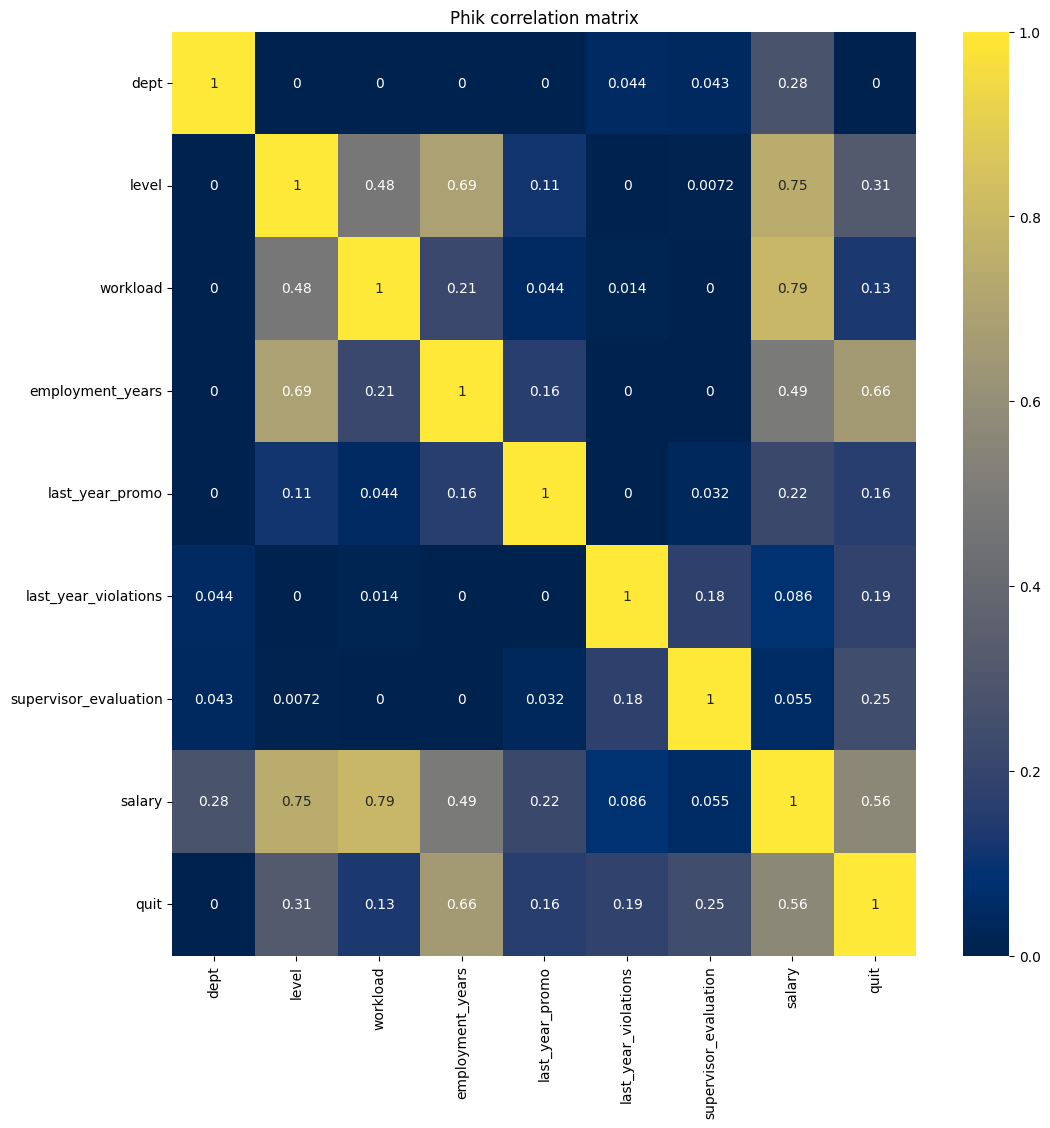

In [58]:
interval_cols_quit = [c for c in continuous if c in train_quit.columns]

phik_corr_quit = train_quit.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [59]:
phik_corr_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000


#### Correlation matrix (Spearman)

****For numerical features, correlations are evaluated using Spearman****


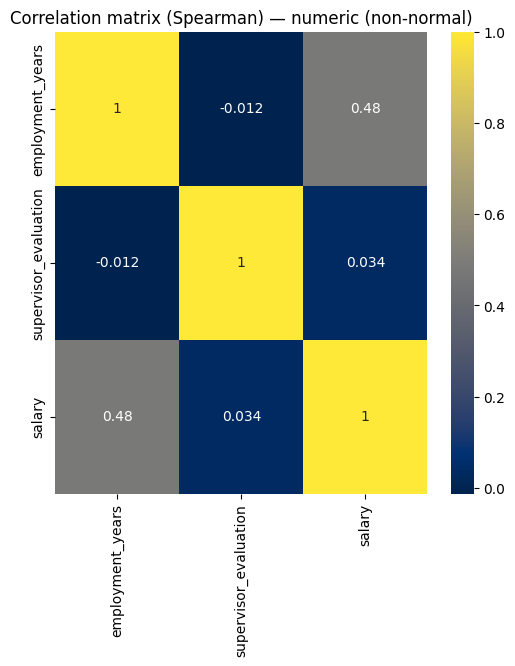

In [60]:
num_cols_quit = train_quit.select_dtypes(include='number').columns.tolist()
num_cols_quit = [c for c in num_cols_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train_quit[num_cols_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [61]:
train_quit[num_cols_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary
employment_years,1.000000,-0.012320,0.478214
supervisor_evaluation,-0.012320,1.000000,0.033737
salary,0.478214,0.033737,1.000000


#### Conclusions from the correlation analysis


****Numerical features (Spearman)****

* No strongly pronounced correlations according to Spearman:

  * `employment_years` ↔ `salary` = **0.48** — a moderate positive relationship (more tenure → higher salary).
  * `supervisor_evaluation` is практически unrelated to other numerical features (|ρ| ≈ **0.01–0.03**).

****Mixed / generalized correlations (Phik)****

**Relationship with the target `quit`:**

* `employment_years` ↔ `quit` = **0.659** — the strongest predictor of attrition.
* `salary` ↔ `quit` = **0.564** — a moderate association.
* `level` ↔ `quit` = **0.313** — weak to moderate.
* `supervisor_evaluation` ↔ `quit` = **0.245** — weak to moderate.
* `last_year_violations` ↔ `quit` = **0.185**, `last_year_promo` ↔ `quit` = **0.157** — weak.
* `workload` ↔ `quit` = **0.132** — weak.
* `dept` ↔ `quit` = **0.000** — no relationship detected.

**Relationships between predictors:**

* `salary` shows strong associations with:

  * `workload` = **0.79**
  * `level` = **0.75**
  * `employment_years` = **0.50**
* `level` ↔ `employment_years` = **0.69** — a pronounced hierarchy–tenure relationship.

****Implications for modeling****

* **Key drivers:**

  * `employment_years` (Phik = **0.659**) — #1.
  * `salary` (**0.564**) — substantial contribution.
  * Followed by `level` (**0.313**) and `supervisor_evaluation` (**0.245**), then discipline/promotions (`last_year_violations` **0.185**, `last_year_promo` **0.157**).

* **Multicollinearity:**

  * No clear linear multicollinearity among numerical predictors (per Spearman).

  * High Phik values (**0.79** for `salary`↔`workload`, **0.75** for `salary`↔`level`) indicate strong associations and potential information redundancy between `salary` and categorical variables (`workload`, `level`).
    Although Phik is non-linear, such magnitudes warn that after encoding (One-Hot/Ordinal) these associations may translate into linear dependencies between `salary` and encoded features.

  * **What to do:**

    * For linear models: use **regularization (L2/L1)** or **feature selection**.
    * For tree-based models: generally acceptable.
    * Consider **interaction features**: `level × workload`, `employment_years × level`.
    * With One-Hot encoding, use `drop='first'`.

****Practical HR takeaway****

The strongest effects on satisfaction and attrition are driven by tenure and role-related structure; compensation plays a secondary role and is largely mediated by job level and workload.


#### Correlation matrix (Phik: numerical + categorical) for the test set


In [62]:
# Merge test_features (feature columns) with test_target_quit (target column)
test_quit_merged = test_features.merge(test_target_quit, on='id')

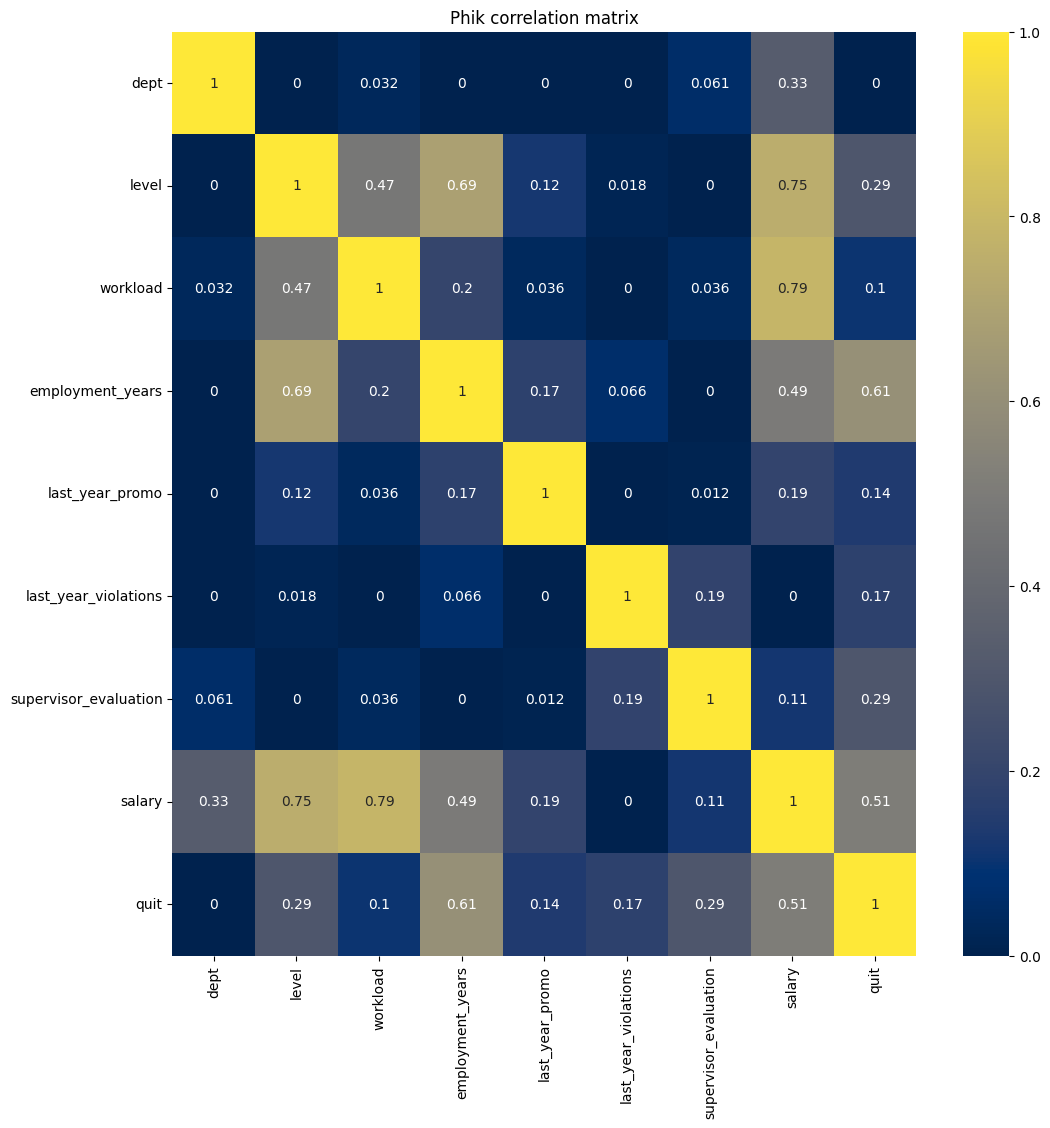

In [63]:
# phik
interval_cols_test_quit = [c for c in continuous if c in test_quit_merged.columns]

phik_corr_test_quit = test_quit_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [64]:
phik_corr_test_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.000000
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.293623
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.102236
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.605927
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.174740
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.294738
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.508308
quit,0.000000,0.293623,0.102236,0.605927,0.137762,0.174740,0.294738,0.508308,1.000000


#### Correlation matrix (Spearman)

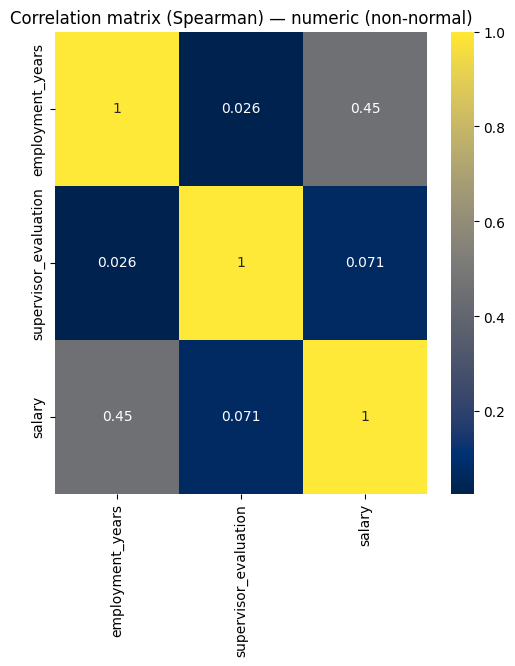

In [65]:
num_cols_test_quit = test_quit_merged.select_dtypes(include='number').columns.tolist()
num_cols_test_quit = [c for c in num_cols_test_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_quit_merged[num_cols_test_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [66]:
test_quit_merged[num_cols_test_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary
employment_years,1.000000,0.026278,0.452343
supervisor_evaluation,0.026278,1.000000,0.071399
salary,0.452343,0.071399,1.000000


#### Conclusions from the correlation analysis (test)

* No significant discrepancies were found between the train and test sets in terms of dependency structure.

* Using the test set to evaluate model performance is appropriate: the patterns of relationships and the relative strength of predictors are consistent with those in the training data.

* Therefore, performance metrics (ROC-AUC, SMAPE) can be compared and interpreted on the test set without the risk of systematic bias due to data distribution differences.


### Profile of an “Employee Who Quit” <a id="employee_profile"></a>


#### Relationship between features and `quit`

**1. Relationship with `employment_years`**


In [67]:
train_quit.groupby('quit')['employment_years'].mean()

quit
no     4.430710
yes    1.844858
Name: employment_years, dtype: float64

In [68]:
phik_corr_quit.loc['quit', 'employment_years']

np.float64(0.6590927481335395)

**Average tenure:**

* Employees who stayed: **4.43 years**
* Employees who quit: **1.84 years**

****Conclusion:****
Attrition primarily affects early-tenure employees with less than 2 years of experience.
Although the Phik correlation is high (**0.66**), the direction of the relationship is inverse: **the shorter the tenure, the higher the probability of quitting**.

In [69]:
# Distribution of employment_years among employees who quit / stayed (in %)
emp_by_quit_pct = (
    train_quit
      .pivot_table(index='employment_years', columns='quit', values='id', aggfunc='count')
      .apply(lambda col: col / col.sum() * 100)
      .fillna(0)
)

emp_by_quit_pct

quit,no,yes
employment_years,,
1,13.440111,53.102837
2,16.956825,25.709220
3,11.002786,14.450355
4,12.743733,2.393617
5,11.803621,2.039007
6,9.958217,0.886525
7,10.480501,0.620567
8,5.954039,0.265957
9,4.630919,0.265957


****Conclusion:****

* The share of employees with **1–2 years of tenure** among those who quit is significantly higher (**53% and 26%**) than among those who stayed (**13% and 17%**).
* Starting from **3 years of tenure**, the proportion of employees who quit drops sharply; with **more than 5 years**, attrition becomes rare (less than **3%**).
* Thus, the **highest attrition risk** is observed among **early-tenure employees (up to 2 years)**, confirming the previously identified inverse relationship between tenure and the probability of leaving.


**2. Relationship with `salary`**


In [70]:
# Average salary by group
train_quit.groupby('quit')['salary'].mean()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

In [71]:
train_quit['salary'].mean()

np.float64(33805.8)

In [72]:
phik_corr_quit.loc['quit', 'salary']

np.float64(0.564153891893097)

****Conclusion:****
Employees who quit earn **below the average salary**.
A gap of nearly **14,000 monetary units** indicates that **lower-paid employees are more likely to leave the company**.


**3. Relationship with `level`**

In [73]:
# Distribution of job levels among employees who quit / stayed (in %)

(train_quit
 .pivot_table(index='level', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
level,,
junior,32.938719,88.918440
middle,55.222841,9.574468
senior,11.838440,1.507092


In [74]:
phik_corr_quit.loc['quit', 'level']

np.float64(0.31279880507754565)

Phik = **0.31** — a moderate association.

****Conclusion:****
Nearly **9 out of 10 employees who quit are junior specialists**.
The higher the job level, the **lower the likelihood of attrition**.


**4. Relationship with workload (`workload`)**


In [75]:
# Distribution of workload among employees who quit / stayed (in %)

(train_quit
 .pivot_table(index='workload', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
workload,,
high,19.254875,10.726950
low,23.990251,46.010638
medium,56.754875,43.262411


In [76]:
phik_corr_quit.loc['quit', 'workload']

np.float64(0.13224343729049595)

Phik = **0.13** — a weak association.

****Conclusion:****
Low and medium workload levels are more prevalent among employees who quit.
This may indicate that employees with lighter workloads are less engaged or feel underutilized.


**5. Relationship with supervisor evaluation (`supervisor_evaluation`)**


In [77]:
# Distribution of supervisor_evaluation among employees who quit / stayed (in %)

(train_quit
 .pivot_table(index='supervisor_evaluation', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
supervisor_evaluation,,
1,3.725627,8.421986
2,7.903900,14.539007
3,24.721448,46.365248
4,47.632312,25.354610
5,16.016713,5.319149


In [78]:
phik_corr_quit.loc['quit', 'supervisor_evaluation']

np.float64(0.24548907299383685)

Phik = **0.25** — a moderate association.

****Conclusion:****
Employees who quit more often receive a **supervisor evaluation of 3**,
whereas a **score of 4** predominates among those who stayed.


**6. Relationship with disciplinary violations (`last_year_violations`)**


In [79]:
# Distribution of last_year_violations among employees who quit / stayed (in %)
(train_quit
 .pivot_table(index='last_year_violations', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
last_year_violations,,
no,88.962396,79.787234
yes,11.037604,20.212766


In [80]:
phik_corr_quit.loc['quit', 'last_year_violations']

np.float64(0.18507136256390683)

Phik = **0.19** — a weak but noticeable association.

****Conclusion:****
Disciplinary violations are **not a strong predictor** of attrition; however, the **share of employees with disciplinary violations is about twice as high among those who quit** compared to those who stayed.


**7. Relationship with promotions (`last_year_promo`)**


In [81]:
# Distribution of last_year_promo among employees who quit / stayed (in %)
(train_quit
 .pivot_table(index='last_year_promo', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
last_year_promo,,
no,96.100279,99.911348
yes,3.899721,0.088652


In [82]:
phik_corr_quit.loc['quit', 'last_year_promo']

np.float64(0.1573700971549875)

Phik = **0.16** — a weak association.

****Conclusion:****
Almost none of the employees who quit received a promotion in the previous year.
The lack of career advancement is likely one of the contributing factors to attrition.

**8. Relationship with department (`dept`)**

In [83]:
# Distribution of departments among employees who quit / stayed (in %)
(train_quit
 .pivot_table(index='dept', columns='quit', values='id', aggfunc='count')
 .apply(lambda col: col / col.sum() * 100))

quit,no,yes
dept,,
hr,12.116992,10.283688
marketing,14.589136,14.450355
purchasing,14.693593,14.716312
sales,35.898329,36.081560
technology,22.701950,24.468085


In [84]:
phik_corr_quit.loc['quit', 'dept']

np.float64(0.0)

Phik = **0.00** — no association.

****Conclusion:****
The probability of attrition does **not depend on the department**.
Departmental structures are virtually identical for both groups.


#### Conclusion

**Key relationships**

1. **Tenure (`employment_years`)**
   Employees who leave are predominantly those with **less than two years** at the company.

2. **Salary (`salary`)**
   Attrition is concentrated among **lower-paid employees** earning below the average compensation level.

3. **Job level (`level`)**
   The probability of leaving **drops sharply as job level increases**; almost all leavers are **junior specialists**.

4. **Workload (`workload`)**
   **Low or medium workload** is more common among those who leave, which may reflect lower engagement or motivation.

5. **Supervisor evaluation (`supervisor_evaluation`)**
   Employees who quit generally receive **lower manager ratings**, suggesting issues with performance or communication.

6. **Disciplinary violations (`last_year_violations`)**
   While violations are not a direct predictor of attrition, their share among leavers is **about twice as high**, indicating a link with lower discipline and engagement.

7. **Promotions (`last_year_promo`)**
   **Lack of career advancement** is a demotivating factor that increases the risk of leaving.

8. **Department (`dept`)**
   Attrition **does not depend on department**; turnover is horizontal rather than function-specific.

---

#### Final profile of an employee who quits

A **typical employee who leaves** is:

* a **junior specialist**,
* with **less than 2 years** of tenure,
* **low salary** (~24k monetary units),
* **manager rating of 3 or lower**,
* **no promotion** in the past year,
* sometimes with **disciplinary violations**,
* **low or medium workload**,
* and **department affiliation is irrelevant**.

---

#### Practical HR implications

* The **primary risk group** is new hires and junior staff.
* **Compensation, career development, and positive managerial feedback** are key retention levers.

**Recommended actions:**

* strengthen onboarding and mentoring during the **first 1–2 years**;
* enhance **reward and internal promotion** systems;
* improve **feedback and engagement** for employees with low workload.


### Testing the hypothesis: “An employee’s job satisfaction level (`job_satisfaction_rate`) affects whether the employee leaves the company.” <a id="hypothesis_test"></a>


We have the following:

* a **test feature set** `test_features` (containing `id`, `dept`, `salary`, `supervisor_evaluation`, etc.);

* the target variable **`job_satisfaction_rate`** (job satisfaction level) from the `test_target` file;

* the target variable **`quit`** (quit / stayed) from the `test_target_quit` file.


#### Merging the data

In [85]:
df = test_features.merge(test_target, on='id').merge(test_target_quit, on='id')

In [86]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


#### Visualization of distributions (how job satisfaction levels are distributed among employees who stayed vs. those who quit)


__Boxplot__

C:\Users\nursu\AppData\Local\Temp\ipykernel_4076\4092631365.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quit', y='job_satisfaction_rate', data=df, palette='Set2')


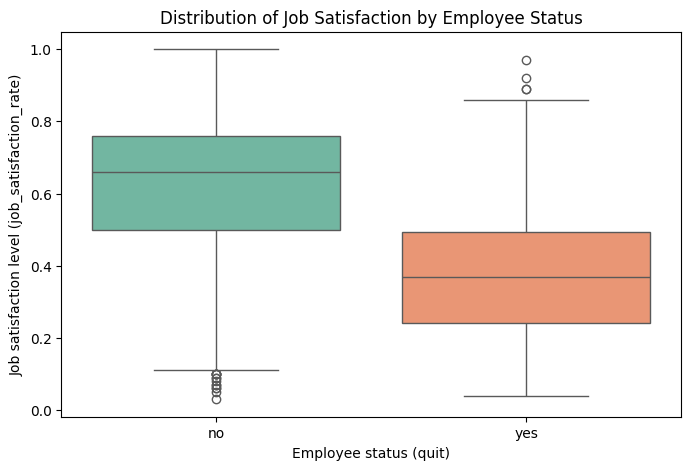

In [87]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='quit', y='job_satisfaction_rate', data=df, palette='Set2')
plt.title('Distribution of Job Satisfaction by Employee Status')
plt.xlabel('Employee status (quit)')
plt.ylabel('Job satisfaction level (job_satisfaction_rate)')
plt.show()


__KDE plot__

C:\Users\nursu\AppData\Local\Temp\ipykernel_4076\853948711.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['quit'] == 'no']['job_satisfaction_rate'], label='Stayed', shade=True)
C:\Users\nursu\AppData\Local\Temp\ipykernel_4076\853948711.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['quit'] == 'yes']['job_satisfaction_rate'], label='Quit', shade=True)


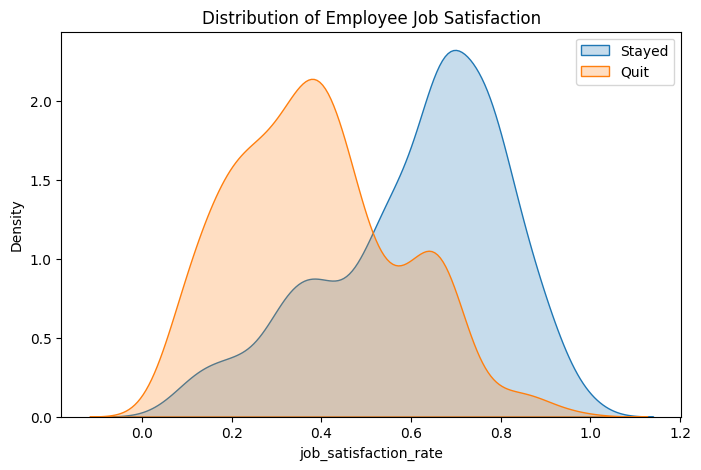

In [88]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['quit'] == 'no']['job_satisfaction_rate'], label='Stayed', shade=True)
sns.kdeplot(df[df['quit'] == 'yes']['job_satisfaction_rate'], label='Quit', shade=True)
plt.title('Distribution of Employee Job Satisfaction')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Density')
plt.legend()
plt.show()


**From the boxplot and KDE density plots**, it is clearly visible that the job satisfaction distributions for the two groups differ substantially:

* **Employees who stayed** have a median satisfaction level of about **0.66**,
  with **75% of values above 0.5** and maxima reaching **1.0**.

* **Employees who quit** have a median satisfaction level of around **0.37**,
  with most of the distribution concentrated in the **0.2–0.5** range.


****Statistical comparison****

In [89]:
df.groupby('quit')['job_satisfaction_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.7600,1.00
yes,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


The **difference in mean values** is approximately **0.22 points**, which is **substantial on a 0–1 scale**.

#### Conclusion

* Job satisfaction level has a **significant impact** on the probability of employee attrition.

* Employees with **low `job_satisfaction_rate` values (below 0.4)** are much more likely to leave the company,
  while those who stay typically show **consistently above-average satisfaction levels (0.6–0.8)**.

* A clear **negative relationship** is observed: **the lower the satisfaction, the higher the risk of quitting**.

* The obtained results **confirm the analysts’ hypothesis** that job satisfaction influences employee turnover.


#### Statistical hypothesis testing

**Objective:** to verify whether the difference in job satisfaction levels (`job_satisfaction_rate`) between employees who quit and those who stayed is statistically significant.

**1. Hypothesis formulation**

* **Null hypothesis (H₀):** the mean values of `job_satisfaction_rate` for employees who quit and those who stayed are equal.
  That is, job satisfaction does not affect the probability of quitting.

* **Alternative hypothesis (H₁):** the mean values of `job_satisfaction_rate` differ between the two groups.
  That is, job satisfaction affects the probability of quitting.


**2. Conducting the test**


In [90]:
# Split the groups
stay = df[df['quit'] == 'no']['job_satisfaction_rate']
leave = df[df['quit'] == 'yes']['job_satisfaction_rate']

# Independent two-sample t-test (unequal variances)
t_stat, p_value = ttest_ind(stay, leave, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.6f}")

T-statistic: 23.795
P-value: 0.000000


****Results:****

T-statistic: **23.795**
P-value: **0.000000**

---

**3. Interpretation**

Since **p-value < 0.05**, the null hypothesis is rejected.
The differences in mean job satisfaction levels between employees who quit and those who stayed are **statistically significant**.

The high t-statistic value (**23.795**) indicates that the difference between group means is much larger than the within-group variability.
Therefore, the observed difference is **not random** and reflects a **real effect** of job satisfaction on employee attrition.

---

**Conclusion**

The results of the t-test confirm that **job satisfaction level is a significant factor in employee turnover**.
The average satisfaction level among employees who stayed is higher, and this difference is statistically reliable.

Thus, the hypothesis that job satisfaction affects attrition is confirmed with a **high degree of confidence**:
**the lower the `job_satisfaction_rate`, the higher the probability that an employee will leave the company.**


### Adding a new input feature <a id="feature_addition"></a>

It is necessary to add one more new feature — **`job_satisfaction_rate_pred`**, which represents the **job satisfaction level predicted by the model from Task 1**.

****Predict `job_satisfaction_rate` and add the column to `train_quit` and `test_features`****


In [91]:
# List of features used to train the model
features = ['dept', 'level', 'workload', 'employment_years',
            'last_year_promo', 'last_year_violations',
            'supervisor_evaluation', 'salary']

train_quit['job_satisfaction_pred'] = best_model.predict(train_quit[features])
test_features['job_satisfaction_pred'] = best_model.predict(test_features[features])


__Verification__

In [92]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.605000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [93]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.643333
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


#### Correlation matrix (Phik: numerical + categorical)


****For the training set****


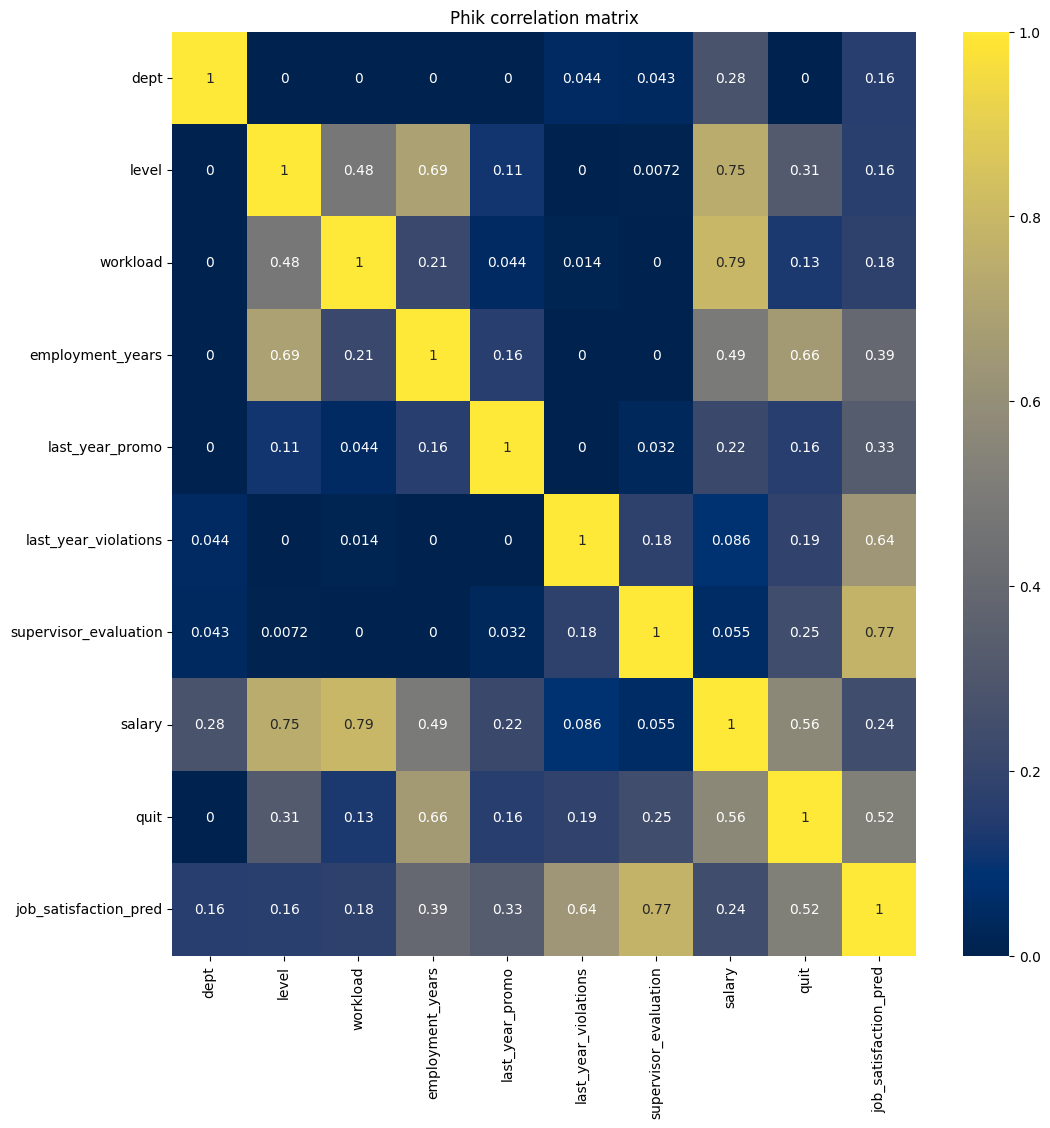

In [94]:
interval_cols_quit = [c for c in continuous if c in train_quit.columns]

phik_corr_quit = train_quit.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [95]:
phik_corr_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_pred
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.156542
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.162732
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.176397
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.391530
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.325295
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.637450
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.773681
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.244994
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.518780
job_satisfaction_pred,0.156542,0.162732,0.176397,0.391530,0.325295,0.637450,0.773681,0.244994,0.518780,1.000000


****For the test set****

In [96]:
# Merge test_features (feature columns) with test_target_quit (target column)
test_quit_merged = test_features.merge(test_target_quit, on='id')

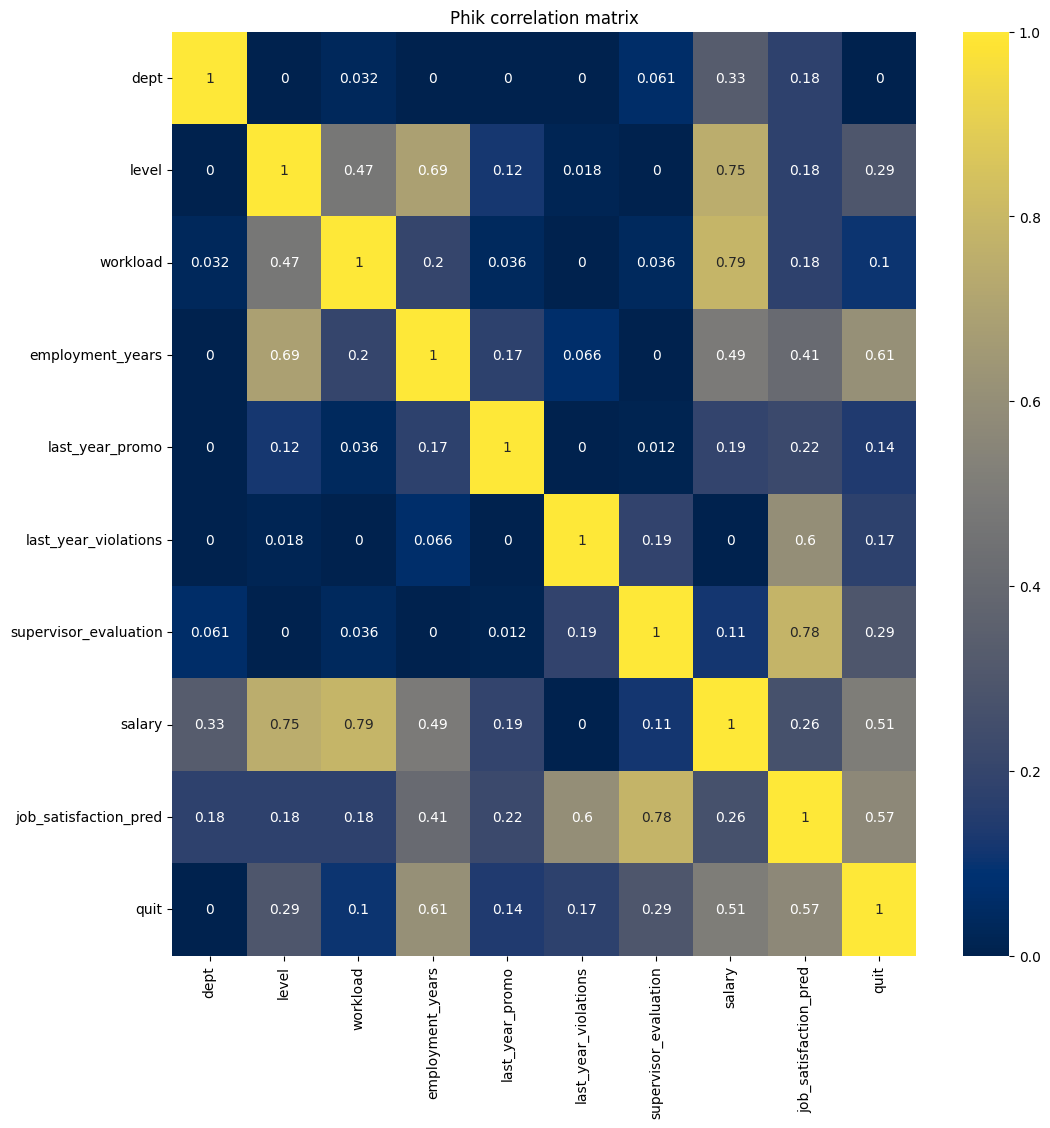

In [97]:
# phik
interval_cols_test_quit = [c for c in continuous if c in test_quit_merged.columns]

phik_corr_test_quit = test_quit_merged.drop(columns=['id']).phik_matrix(
    interval_cols=interval_cols_test_quit
)

plt.figure(figsize=(12, 12))
sns.heatmap(phik_corr_test_quit, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [98]:
phik_corr_test_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_pred,quit
dept,1.000000,0.000000,0.032212,0.000000,0.000000,0.000000,0.061389,0.330327,0.178692,0.000000
level,0.000000,1.000000,0.474370,0.689666,0.118258,0.017527,0.000000,0.748998,0.176253,0.293623
workload,0.032212,0.474370,1.000000,0.202096,0.035565,0.000000,0.035920,0.785872,0.179117,0.102236
employment_years,0.000000,0.689666,0.202096,1.000000,0.173637,0.066371,0.000000,0.494701,0.406888,0.605927
last_year_promo,0.000000,0.118258,0.035565,0.173637,1.000000,0.000000,0.011704,0.193727,0.219215,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.600976,0.174740
supervisor_evaluation,0.061389,0.000000,0.035920,0.000000,0.011704,0.189719,1.000000,0.114588,0.782190,0.294738
salary,0.330327,0.748998,0.785872,0.494701,0.193727,0.000000,0.114588,1.000000,0.262841,0.508308
job_satisfaction_pred,0.178692,0.176253,0.179117,0.406888,0.219215,0.600976,0.782190,0.262841,1.000000,0.568785
quit,0.000000,0.293623,0.102236,0.605927,0.137762,0.174740,0.294738,0.508308,0.568785,1.000000


#### Correlation matrix (Spearman)

****For the training set****

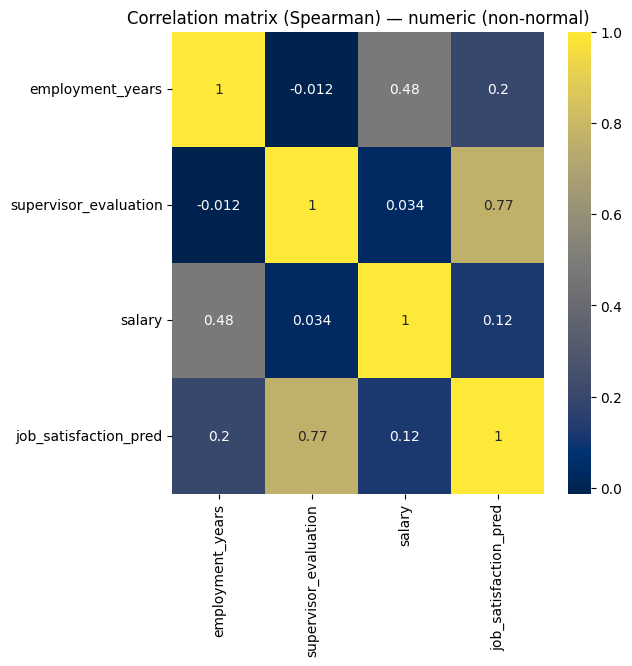

In [99]:
num_cols_quit = train_quit.select_dtypes(include='number').columns.tolist()
num_cols_quit = [c for c in num_cols_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(train_quit[num_cols_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [100]:
train_quit[num_cols_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_pred
employment_years,1.000000,-0.012320,0.478214,0.200210
supervisor_evaluation,-0.012320,1.000000,0.033737,0.765234
salary,0.478214,0.033737,1.000000,0.122123
job_satisfaction_pred,0.200210,0.765234,0.122123,1.000000


****For the test set****

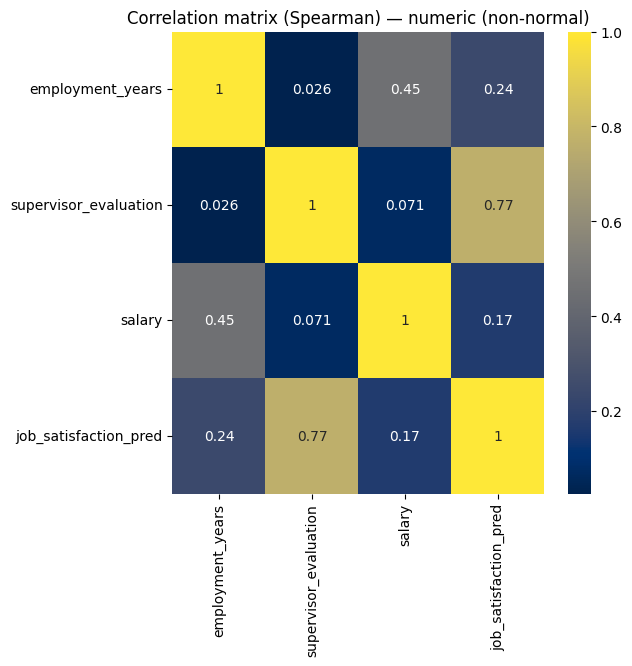

In [101]:
num_cols_test_quit = test_quit_merged.select_dtypes(include='number').columns.tolist()
num_cols_test_quit = [c for c in num_cols_test_quit if c != 'id']

plt.figure(figsize=(6, 6))
sns.heatmap(test_quit_merged[num_cols_test_quit].corr(method='spearman'), annot=True, cmap='cividis')
plt.title('Correlation matrix (Spearman) — numeric (non-normal)')
plt.show()

In [102]:
test_quit_merged[num_cols_test_quit].corr(method='spearman')

,employment_years,supervisor_evaluation,salary,job_satisfaction_pred
employment_years,1.000000,0.026278,0.452343,0.239453
supervisor_evaluation,0.026278,1.000000,0.071399,0.766747
salary,0.452343,0.071399,1.000000,0.165910
job_satisfaction_pred,0.239453,0.766747,0.165910,1.000000


#### Conclusions from the correlation analysis

****Phik (numerical + categorical)****

**Train (train_quit):**

* Relationship with the target `quit`:
  `job_satisfaction_pred` ↔ `quit` = **0.519** — a **moderate association**; the feature is informative but not dominant.
* The strongest associations of `job_satisfaction_pred` are with:
  `supervisor_evaluation` (**0.774**), `last_year_violations` (**0.637**).
* No clearly strong associations among the predictors themselves are observed.

**Test (test_quit_merged):**

* `job_satisfaction_pred` ↔ `quit` = **0.569** — slightly higher than on train, but within the same (moderate) range.
* The association profile with other factors is preserved: strongest with
  `supervisor_evaluation` (**0.782**), followed by `last_year_violations` (**0.601**).
* No clearly strong associations among predictors are observed.

**Phik conclusion:** the dependency structure is **stable between train and test**.

---

****Spearman (numerical only)****

**Train:**

* `job_satisfaction_pred` shows a high correlation with `supervisor_evaluation` (ρ ≈ **0.765**).
* No clear linear multicollinearity among numerical features is detected.

**Test:**

* The pattern is similar to train:
  `job_satisfaction_pred` ↔ `supervisor_evaluation` (ρ ≈ **0.767**) — high.

**Spearman conclusion:** linear dependence among numerical predictors is **moderate**, with **no critical pairs** exhibiting excessively high correlations.

### Data Preparation <a id="data_preparation"></a>

**Data Preparation**

* A **single `ColumnTransformer`** is used.

* **OneHotEncoder** for nominal features (`dept`) with `drop='first'`.

* **OrdinalEncoder** for ordered categorical features (`level`, `workload`, `last_year_promo`, `last_year_violations`) with a specified class order; **pre- and post-imputation with mode** is applied to handle missing or unseen categories robustly.

* **Numerical features** (`employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_pred`) undergo **median imputation** and **scaling** (`StandardScaler` / `MinMaxScaler` / `passthrough`), with the best option selected via cross-validation.

****Remove `id` column and check for duplicates****

In [103]:
train_quit.drop(columns=['id']).duplicated().sum()

np.int64(1413)

****Removing duplicates****

In [104]:
train_2_no_id = train_quit.drop(columns=['id']).drop_duplicates(keep='first')
print(f"Size before: {train_quit.drop(columns=['id']).shape}, after: {train_2_no_id.shape}")

Size before: (4000, 10), after: (2587, 10)


In [105]:
X_train_2 = train_2_no_id.drop(columns=['quit'])
y_train_2 = train_2_no_id['quit']

****Result:****

* **1,413 full duplicates** were detected and removed.
* The training set size decreased from **4,000 → 2,587 rows**, improving data quality.
* Splitting into `X_train_2` and `y_train_2` was performed **after deduplication**, so indices are aligned.
* The check was performed only on the training set; the test set remains unchanged to **simulate a real-world data flow**.

In [106]:
X_test_2 = test_features.set_index('id').sort_index()
y_test_2 = (test_target_quit
          .set_index('id')
          .sort_index()['quit']) 

label_encoder = LabelEncoder()
y_train_2_label = label_encoder.fit_transform(y_train_2)
y_test_2_label = label_encoder.transform(y_test_2)

In [107]:
print("Dataset shapes:")
print("X_train_2:", X_train_2.shape)
print("X_test_2:", X_test_2.shape)
print("y_train_2_label:", y_train_2_label.shape)
print("y_test_2_label:", y_test_2_label.shape)

# Feature lists
# OHE: nominal categorical features
ohe_columns_2 = ['dept']

# Ordinal: ordered categorical features
ord_columns_2 = ['level', 'workload', 'last_year_promo', 'last_year_violations']

# Numerical features (excluding target and id)
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_pred']

# --- pipelines for encoding / imputation ---
ohe_pipe_2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Categories order
ord_categories_2 = [
    ['junior', 'middle', 'senior'],   # level
    ['low', 'medium', 'high'],        # workload
    ['no', 'yes'],                    # last_year_promo
    ['no', 'yes']                     # last_year_violations
]

ord_pipe_2 = Pipeline(steps=[
    ('impute_before', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=ord_categories_2,
                           handle_unknown='use_encoded_value',
                           unknown_value=np.nan)),
    ('impute_after', SimpleImputer(strategy='most_frequent'))
])

num_pipe_2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# --- full preprocessor ---
data_preprocessor_2 = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', num_pipe_2, num_columns_2),
    ],
    remainder='drop'
)

Dataset shapes:
X_train_2: (2587, 9)
X_test_2: (2000, 9)
y_train_2_label: (2587,)
y_test_2_label: (2000,)


****Encoding is performed using `LabelEncoder`.****
****Check of assigned labels:****

In [108]:
pd.DataFrame(y_train_2_label, y_train_2, columns=['LabelEncoder']).head()

,LabelEncoder
quit,
no,0
no,0
no,0
yes,1
no,0


### Model Training (Task 2: Predict `quit`) <a id="model_training"></a>

****Metric:**** ROC-AUC

****Objective:**** binary classification (`quit`: yes/no)

****Features:**** all features from Task 1 **plus** `job_satisfaction_pred` (prediction from Task 1).


#### Decision Tree Classifier

* **Full pipeline:** `preprocessor` + `DecisionTreeClassifier`.
* Hyperparameters tuned via `RandomizedSearchCV` (cv=5, scoring='roc_auc', n_iter=35):

  * `max_depth`, `min_samples_split`, `min_samples_leaf`
  * Type of **numerical scaling** via `preprocessor__num__scale` (not critical for trees but allowed)


In [109]:
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions_1 = {
    'model__max_depth': range(2, 20),
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(2, 10),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}

randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_distributions_1, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=35,
    n_jobs=-1
)

randomized_search_1.fit(X_train_2, y_train_2_label)

print("Best parameters:", randomized_search_1.best_params_)
print("Best ROC-AUC:", randomized_search_1.best_score_)


Best parameters: {'preprocessor__num__scale': StandardScaler(), 'model__min_samples_split': 4, 'model__min_samples_leaf': 6, 'model__max_depth': 5}
Best ROC-AUC: 0.9030844586055874


**Best parameters:**

```python
{'preprocessor__num__scale': StandardScaler(), 
 'model__min_samples_split': 4, 
 'model__min_samples_leaf': 6, 
 'model__max_depth': 5}
```

**Best ROC-AUC (CV):** 0.903

---

**Conclusion:**
The decision tree with **moderate depth** and **leaf constraints** achieved high performance (**ROC-AUC ≈ 0.903**).
Scaling is not necessary for trees, but in combination with categorical encodings it may slightly improve the stability of splits.


#### K-Nearest Neighbors (KNN) Classifier

* **Full pipeline:** `preprocessor` + `KNeighborsClassifier`.

* Hyperparameters to tune: `n_neighbors` and **type of numerical scaling** via `preprocessor__num__scale`.

* **Scaling is required** for KNN to ensure proper distance computations.

In [110]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', KNeighborsClassifier())
])

param_distributions_2 = {
    'model__n_neighbors': range(2, 15),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler()] 
}

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_distributions_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=25,
    n_jobs=-1
)

randomized_search_2.fit(X_train_2, y_train_2_label)

print("Best parameters:", randomized_search_2.best_params_)
print("Best ROC-AUC:", randomized_search_2.best_score_)

Best parameters: {'preprocessor__num__scale': StandardScaler(), 'model__n_neighbors': 14}
Best ROC-AUC: 0.8978644892274236


**Best parameters:**

```python
{'preprocessor__num__scale': StandardScaler(), 'model__n_neighbors': 14}
```

**Best ROC-AUC (CV):** 0.897

---

**Conclusion:**
The **KNN model** demonstrated stable performance (**ROC-AUC ≈ 0.897**).
Using **StandardScaler** was optimal — it reduced feature scale distortions and improved model results.


#### Logistic Regression

* **Full pipeline:** `preprocessor` + `LogisticRegression` with **L1 regularization**.
* Hyperparameters to tune: **C** (regularization strength) and **type of numerical scaling**.
* **Solver:** `'liblinear'` is used for L1.
* Target variable is **binary** (0/1).

In [111]:
pipe_final_3 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
])

param_distributions_3 = {
    'model__C': range(1, 15),
    'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']  
}

randomized_search_3 = RandomizedSearchCV(
    pipe_final_3, 
    param_distributions_3, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=20,
    n_jobs=-1
)

randomized_search_3.fit(X_train_2, y_train_2_label)

print("Best parameters:", randomized_search_3.best_params_)
print("Best ROC-AUC:", randomized_search_3.best_score_)

Best parameters: {'preprocessor__num__scale': 'passthrough', 'model__C': 9}
Best ROC-AUC: 0.9010193805092758


**Best parameters:**

```python
{'preprocessor__num__scale': 'passthrough', 'model__C': 9}
```

**Best ROC-AUC (CV):** 0.901

---

**Conclusion:**
The **Logistic Regression** model achieved performance comparable to the decision tree (**ROC-AUC ≈ 0.90**) but is **less flexible**.
L1 regularization helped **exclude less informative features** and **reduce overfitting**, while maintaining the **interpretability** of the model.


#### Evaluation on the test set and conclusion

After comparative cross-validation analysis, the **Decision Tree Classifier** was selected for final evaluation on the test set as the **best-performing model according to ROC-AUC**.


In [112]:
best_model_2 = randomized_search_1.best_estimator_
y_pred_proba = best_model_2.predict_proba(X_test_2)[:, 1]
test_auc = roc_auc_score(y_test_2_label, y_pred_proba)
print(f"ROC-AUC on the test set: {test_auc:.3f}")

ROC-AUC on the test set: 0.912


****Results:****

* **CV ROC-AUC:** 0.903
* **Test ROC-AUC:** 0.912

---

**Final conclusion:**

The **Decision Tree Classifier** achieved the highest ROC-AUC (CV ≈ 0.903, Test ≈ 0.912).
KNN and Logistic Regression showed comparable performance (ROC-AUC ≈ 0.897 and 0.901, respectively), but the decision tree has several advantages.

---

**Why the tree is better for this task**

* **Nonlinearity:** it captures threshold effects and interactions between categorical and numerical features.
* **Robustness:** low sensitivity to feature scaling and outliers.
* **Complexity control:** optimal `max_depth`, `min_samples_split`, and `min_samples_leaf` limit overfitting.

---

**Conclusion:**

The **Decision Tree Classifier** successfully met the success criterion for ROC-AUC and can be recommended as the **primary model for predicting employee attrition probability (`quit`)**.


In [113]:
# Baseline model — predicts the most frequent class
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train_2, y_train_2_label)

# Predictions and ROC-AUC
dummy_pred = dummy.predict_proba(X_test_2)[:, 1]
dummy_auc = roc_auc_score(y_test_2_label, dummy_pred)

best_auc = roc_auc_score(y_test_2_label, randomized_search_1.predict_proba(X_test_2)[:, 1])

print(f'ROC-AUC DummyClassifier: {dummy_auc:.3f}')
print(f'ROC-AUC DecisionTreeClassifier: {best_auc:.3f}')
print(f'Improvement over baseline: {best_auc - dummy_auc:.3f}')


ROC-AUC DummyClassifier: 0.500
ROC-AUC DecisionTreeClassifier: 0.912
Improvement over baseline: 0.412


****Result:****

The **Decision Tree Classifier** achieved a ROC-AUC **significantly higher** than the DummyClassifier, confirming its adequacy and genuine predictive power.

Thus, the final model is truly **capturing patterns in the data**, rather than simply reproducing a constant baseline prediction.


## Overall Project Conclusion <a id="overall_conclusion"></a>

**Overall Conclusion**

The project successfully addressed a key HR-analytics business problem — **predicting employee job satisfaction and the likelihood of attrition** using internal company data. The results not only identified the main factors influencing motivation and engagement but also provided **practical recommendations to reduce turnover and improve employee retention**.

---

**Project Stages**

1. **Data Preprocessing and Exploration**
   A detailed analysis was performed on the employee dataset, including department, job level, tenure, workload, disciplinary violations, promotions, salary, and supervisor evaluation.
   Missing values were identified and imputed logically based on similar observations.

2. **Data Preparation**
   Steps performed included:

   * Imputation of missing values
   * Encoding categorical features (One-Hot, OrdinalEncoder)
   * Scaling numerical variables (StandardScaler, MinMaxScaler)
   * Removal of non-informative features (`id`)

3. **Model Building and Training**
   Various machine learning algorithms were applied:

   * **Decision Tree Regressor** — for predicting job satisfaction
   * **Ridge Regression** — for assessing linear effects with L2 regularization
   * **Decision Tree Classifier**, **K-Nearest Neighbors (KNN)**, and **Logistic Regression (L1)** — for predicting employee attrition
     Hyperparameter tuning was performed using `RandomizedSearchCV` (cv=5, scoring by SMAPE and ROC-AUC).

4. **Model Evaluation and Comparison**

   * For job satisfaction prediction, **DecisionTreeRegressor** achieved the best performance (**Test SMAPE ≈ 13.35%**)
   * For attrition prediction, **DecisionTreeClassifier** led with **ROC-AUC = 0.912 on the test set**
     This confirmed the effectiveness of decision trees for datasets with mixed feature types and nonlinear relationships.

---

**Key Findings**

* Main drivers of employee satisfaction: **supervisor evaluation** and **absence of disciplinary violations**
* **Salary, tenure, and job level** are interrelated and influence attrition probability indirectly
* Primary risk group: **new hires and junior specialists** with low or medium workload and low supervisor evaluation
* Models confirmed that combining **objective factors** (salary, tenure) and **subjective factors** (evaluation, engagement) provides the most accurate prediction of employee behavior

---

**Business Recommendations**

1. Develop onboarding and mentoring programs for employees with tenure under 2 years
2. Strengthen rewards and career growth systems, as lack of promotion is directly linked to higher attrition risk
3. Increase manager engagement in team management — supervisor evaluation is the main predictor of satisfaction
4. Implement predictive HR analytics to track satisfaction dynamics and automatically identify attrition risk groups
5. Use the models as the foundation for a **“smart HR management system”** that integrates prediction, visualization, and actionable recommendations

---

**Final Summary**

The project demonstrated that **machine learning methods can automate HR data analysis**, improve forecast accuracy, and shift from reactive personnel management to a **proactive retention strategy**.
Implementing such models can be a step toward an **intelligent human capital management system**, combining satisfaction prediction, attrition risk assessment, and recommendations to enhance motivation and employee performance.
